# Sampling on all angles

Sample on all angles learned by model

In [1]:
import os, sys
import logging
import json
import glob
import importlib
import math

import torch

import numpy as np
from scipy import stats
from matplotlib import pyplot as plt
import seaborn as sns
#############

SRC_DIR = os.path.join(
    os.path.dirname(os.getcwd()), "protdiff"
)
assert os.path.isdir(SRC_DIR)
sys.path.append(SRC_DIR)
import beta_schedules
import datasets
import plotting
import sampling
import modelling
import utils

BIN_DIR = os.path.join(
    os.path.dirname(os.getcwd()), "bin"
)
assert os.path.isdir(BIN_DIR)
sys.path.append(BIN_DIR)
import train as train_bin

logging.basicConfig(level=logging.INFO)

In [2]:
# This is the version of the model trained locally with the old trRosetta angles
# MODEL_DIR = "/home/t-kevinwu/projects/protein_diffusion/temp/results"
# is_legacy = True

# This is the version of the model trained on singularity with the old trRosetta angles
# MODEL_DIR = "/home/t-kevinwu/amlt/adapted-stud/cath_full_run/results"
# is_legacy = False

# This is the version of the model with the canonical dihedral angles
# MODEL_DIR = "/home/t-kevinwu/amlt/normal-cattle/cath_full_run/results"
# is_legacy = False

# This is the version of the model with canonical dihedral angels and NO DISTANCES
MODEL_DIR = "/home/t-kevinwu/amlt/top-bengal/cath_full_run/results"
is_legacy = False

with open(os.path.join(MODEL_DIR, "training_args.json")) as source:
    training_args = json.load(source)
training_args


{'results_dir': '/mnt/output/projects/protdiff-cath/amlt-results/7338443611.59698-5ac843bc-dae2-4598-91f5-8f2fa1616fa3/results',
 'angles_definitions': 'canonical_angles_only',
 'shift_angles_zero_twopi': False,
 'noise_prior': 'gaussian',
 'timesteps': 250,
 'variance_schedule': 'linear',
 'variance_scale': 1.0,
 'implementation': 'huggingface_encoder',
 'time_encoding': 'gaussian_fourier',
 'num_hidden_layers': 12,
 'hidden_size': 384,
 'intermediate_size': 768,
 'num_heads': 12,
 'position_embedding_type': 'absolute',
 'dropout_p': 0.1,
 'decoder': 'mlp',
 'gradient_clip': 1.0,
 'batch_size': 64,
 'lr': 5e-05,
 'loss': 'smooth_l1',
 'l2_norm': 0.0,
 'l1_norm': 0.0,
 'circle_reg': 0.0,
 'min_epochs': 10000,
 'max_epochs': 10000,
 'early_stop_patience': 0,
 'lr_scheduler': '',
 'use_swa': False,
 'subset': None,
 'exhaustive_validation_t': False,
 'syn_noiser': '',
 'single_dist_debug': False,
 'single_angle_debug': -1,
 'single_timestep_debug': False,
 'cpu_only': False,
 'ngpu': -1,

In [3]:
beta_values = beta_schedules.get_variance_schedule(
    training_args['variance_schedule'],
    training_args['timesteps'],
)
alpha_beta_values = beta_schedules.compute_alphas(beta_values)
alpha_beta_values.keys()

INFO:root:Getting linear variance schedule with 250 timesteps


dict_keys(['betas', 'alphas', 'alphas_cumprod', 'sqrt_alphas_cumprod', 'sqrt_one_minus_alphas_cumprod', 'posterior_variance'])

In [4]:
# Load in the dataset
importlib.reload(train_bin)
importlib.reload(datasets)

dset_args = dict(
    timesteps=training_args['timesteps'],
    variance_schedule=training_args['variance_schedule'],
    noise_prior=training_args['noise_prior'],
    shift_to_zero_twopi=training_args['shift_angles_zero_twopi'],
    var_scale=training_args['variance_scale'],
    toy=training_args['subset'],
    syn_noiser=training_args['syn_noiser'],
    exhaustive_t=training_args['exhaustive_validation_t'],
    single_dist_debug=training_args['single_dist_debug'],
    single_angle_debug=training_args['single_angle_debug'],
    single_time_debug=training_args['single_timestep_debug'],
)
if 'angles_definitions' in training_args:
    dset_args['angles_definitions'] = training_args['angles_definitions']

train_dset, valid_dset, test_dset = train_bin.get_train_valid_test_sets(**dset_args)
train_dset

INFO:root:Loading cached full dataset from /home/t-kevinwu/protdiff/protdiff/cache_canonical_structures.pkl
INFO:root:Split train contains 25224 structures
INFO:root:Length of angles: 9-1202, mean 152.32354107199492
INFO:root:CATH canonical angles only dataset with ['phi', 'psi', 'omega', 'tau'] (subset idx [1, 2, 3, 4])
INFO:root:Loading cached full dataset from /home/t-kevinwu/protdiff/protdiff/cache_canonical_structures.pkl
INFO:root:Split validation contains 3153 structures
INFO:root:Length of angles: 13-773, mean 150.05962575325088
INFO:root:CATH canonical angles only dataset with ['phi', 'psi', 'omega', 'tau'] (subset idx [1, 2, 3, 4])
INFO:root:Loading cached full dataset from /home/t-kevinwu/protdiff/protdiff/cache_canonical_structures.pkl
INFO:root:Split test contains 3154 structures
INFO:root:Length of angles: 13-1072, mean 151.2263792010146
INFO:root:CATH canonical angles only dataset with ['phi', 'psi', 'omega', 'tau'] (subset idx [1, 2, 3, 4])
INFO:root:Using <class 'datas

In [5]:
train_dset.dset.feature_names['angles']

['phi', 'psi', 'omega', 'tau']

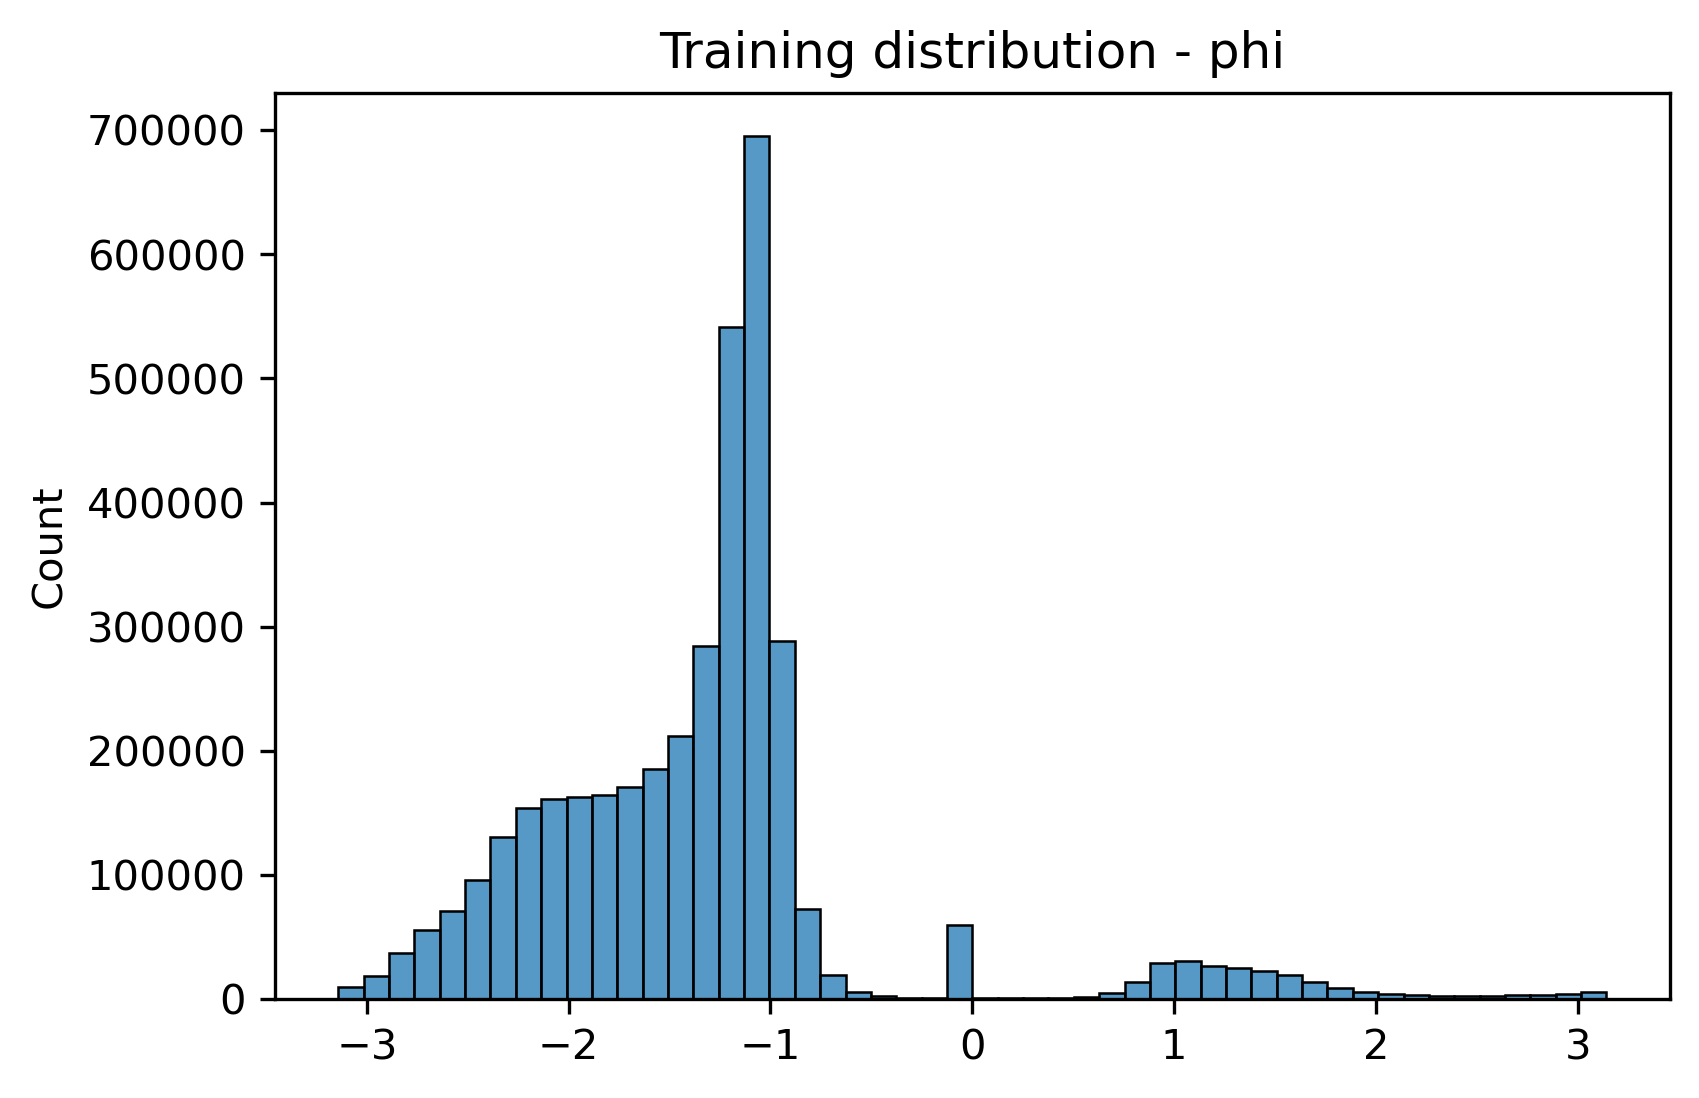

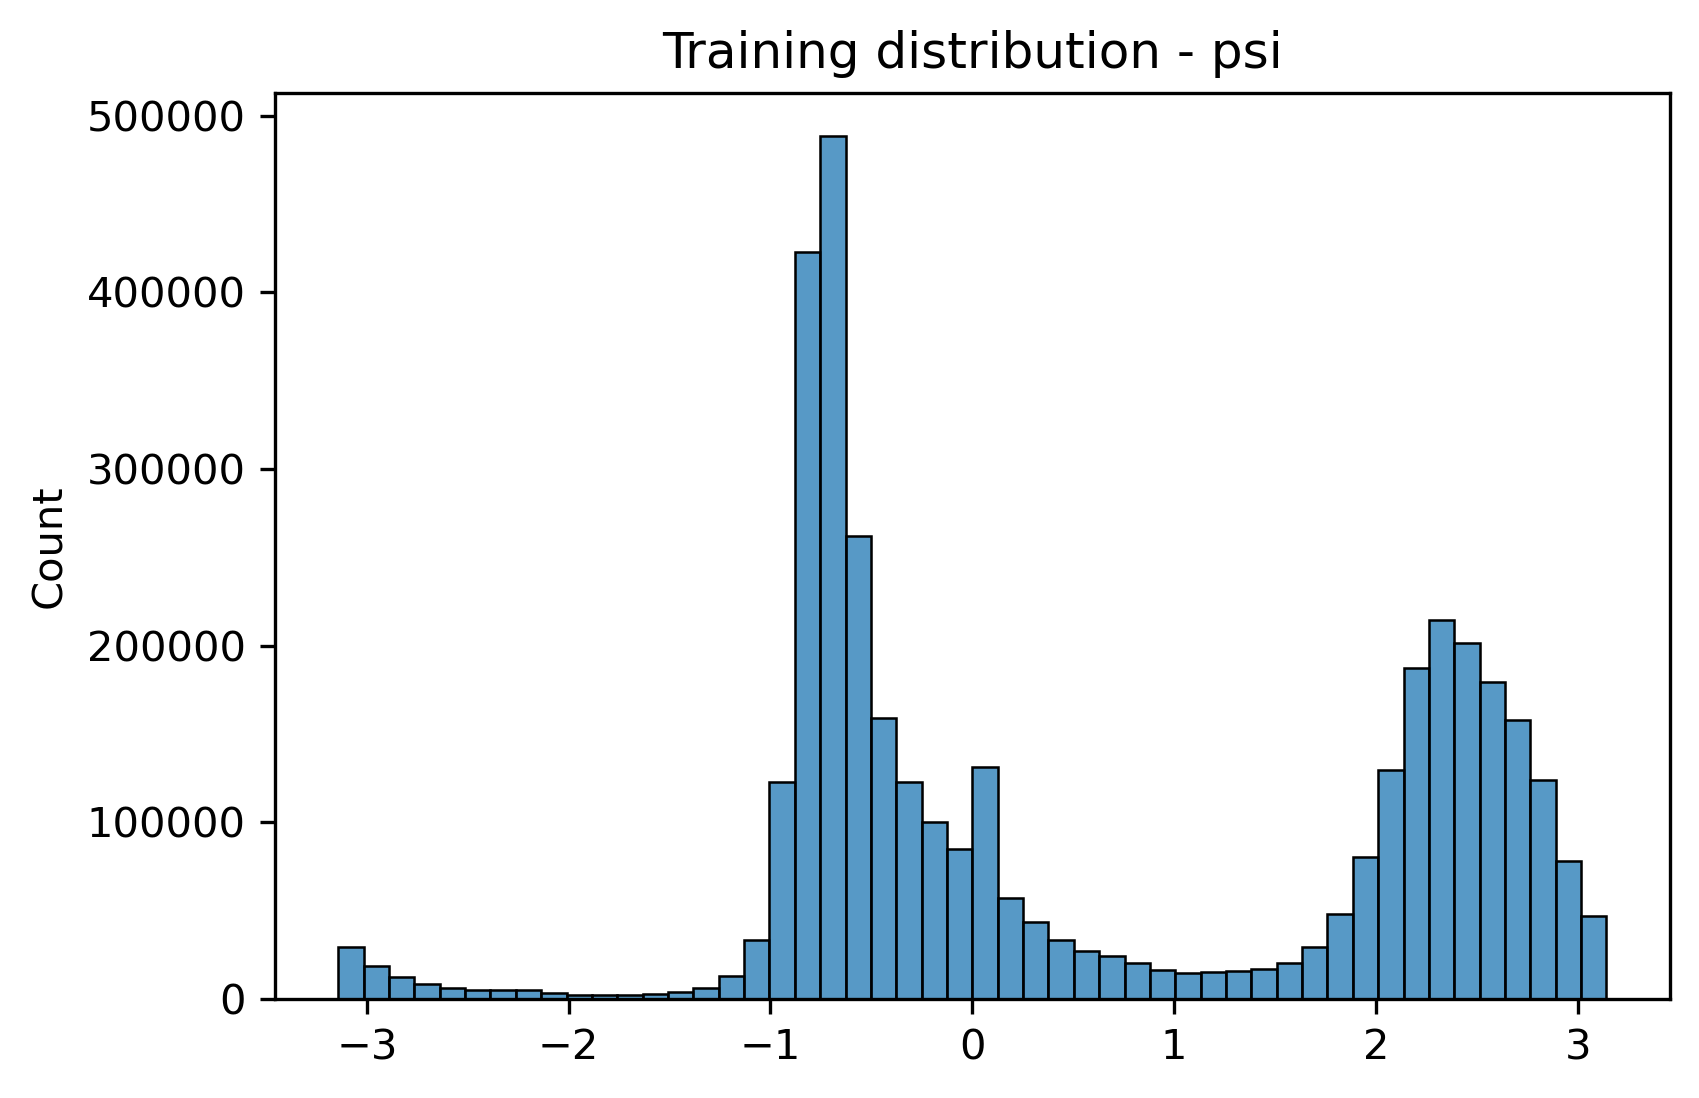

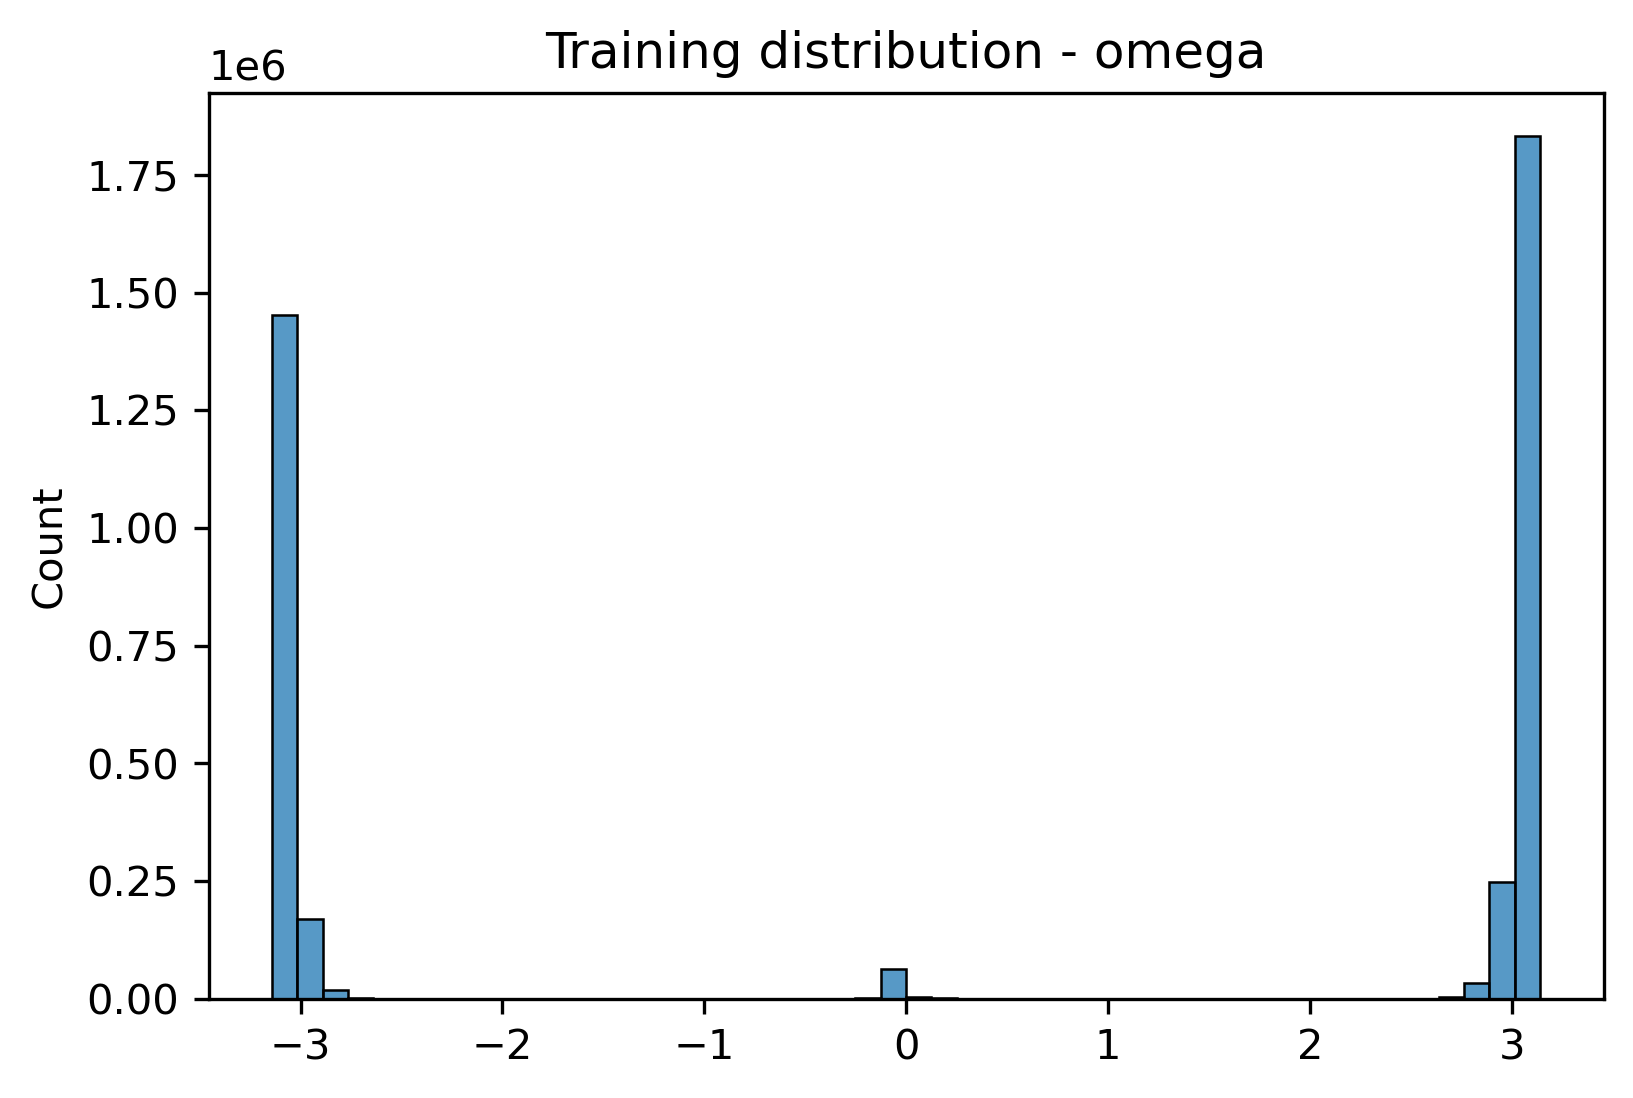

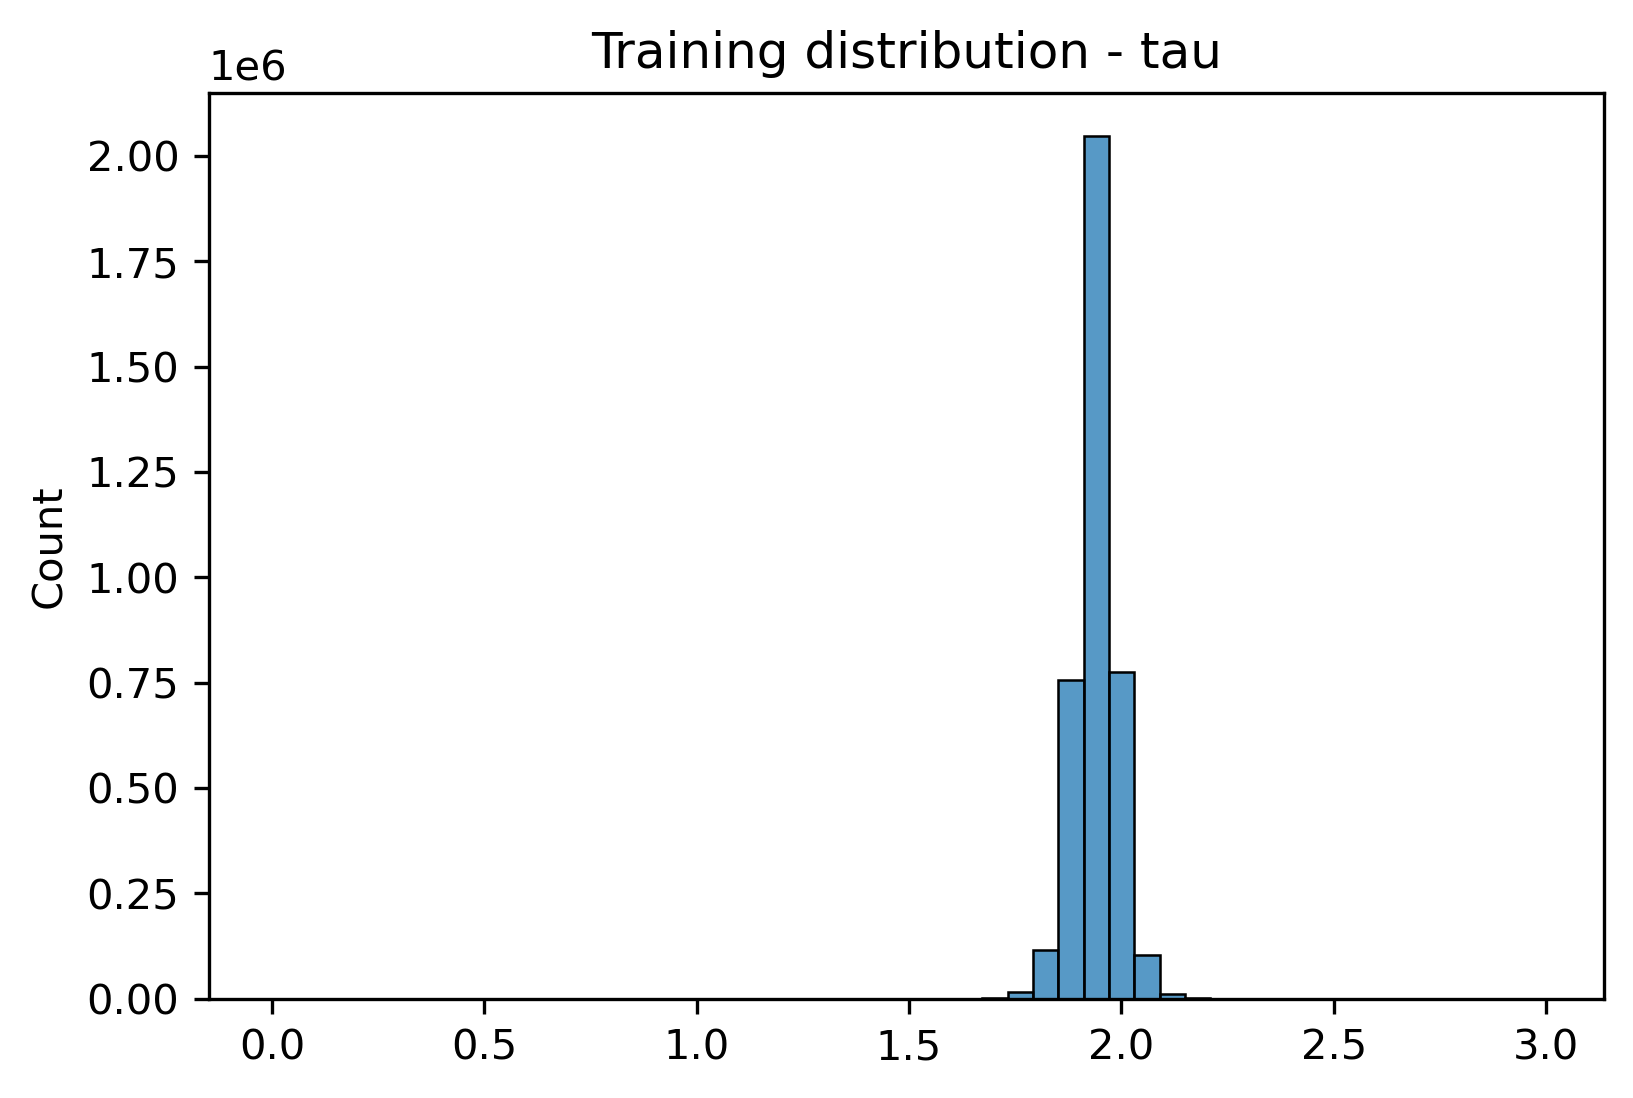

In [6]:
select_by_attn = lambda x: x['angles'][x['attn_mask'] != 0]

# Select the un-noised angles
train_values = [select_by_attn(train_dset.dset[i]) for i in range(len(train_dset))]

train_values_stacked = torch.cat(train_values, dim=0)

for i in range(train_values_stacked.shape[1]):
    ft_name = train_dset.dset.feature_names['angles'][i]
    fig, ax = plt.subplots(dpi=300)
    sns.histplot(train_values_stacked[:, i], bins=50, ax=ax)
    ax.set(title=f"Training distribution - {ft_name}")
    fig.show()

In [7]:
train_values_stacked.shape

torch.Size([3832103, 4])

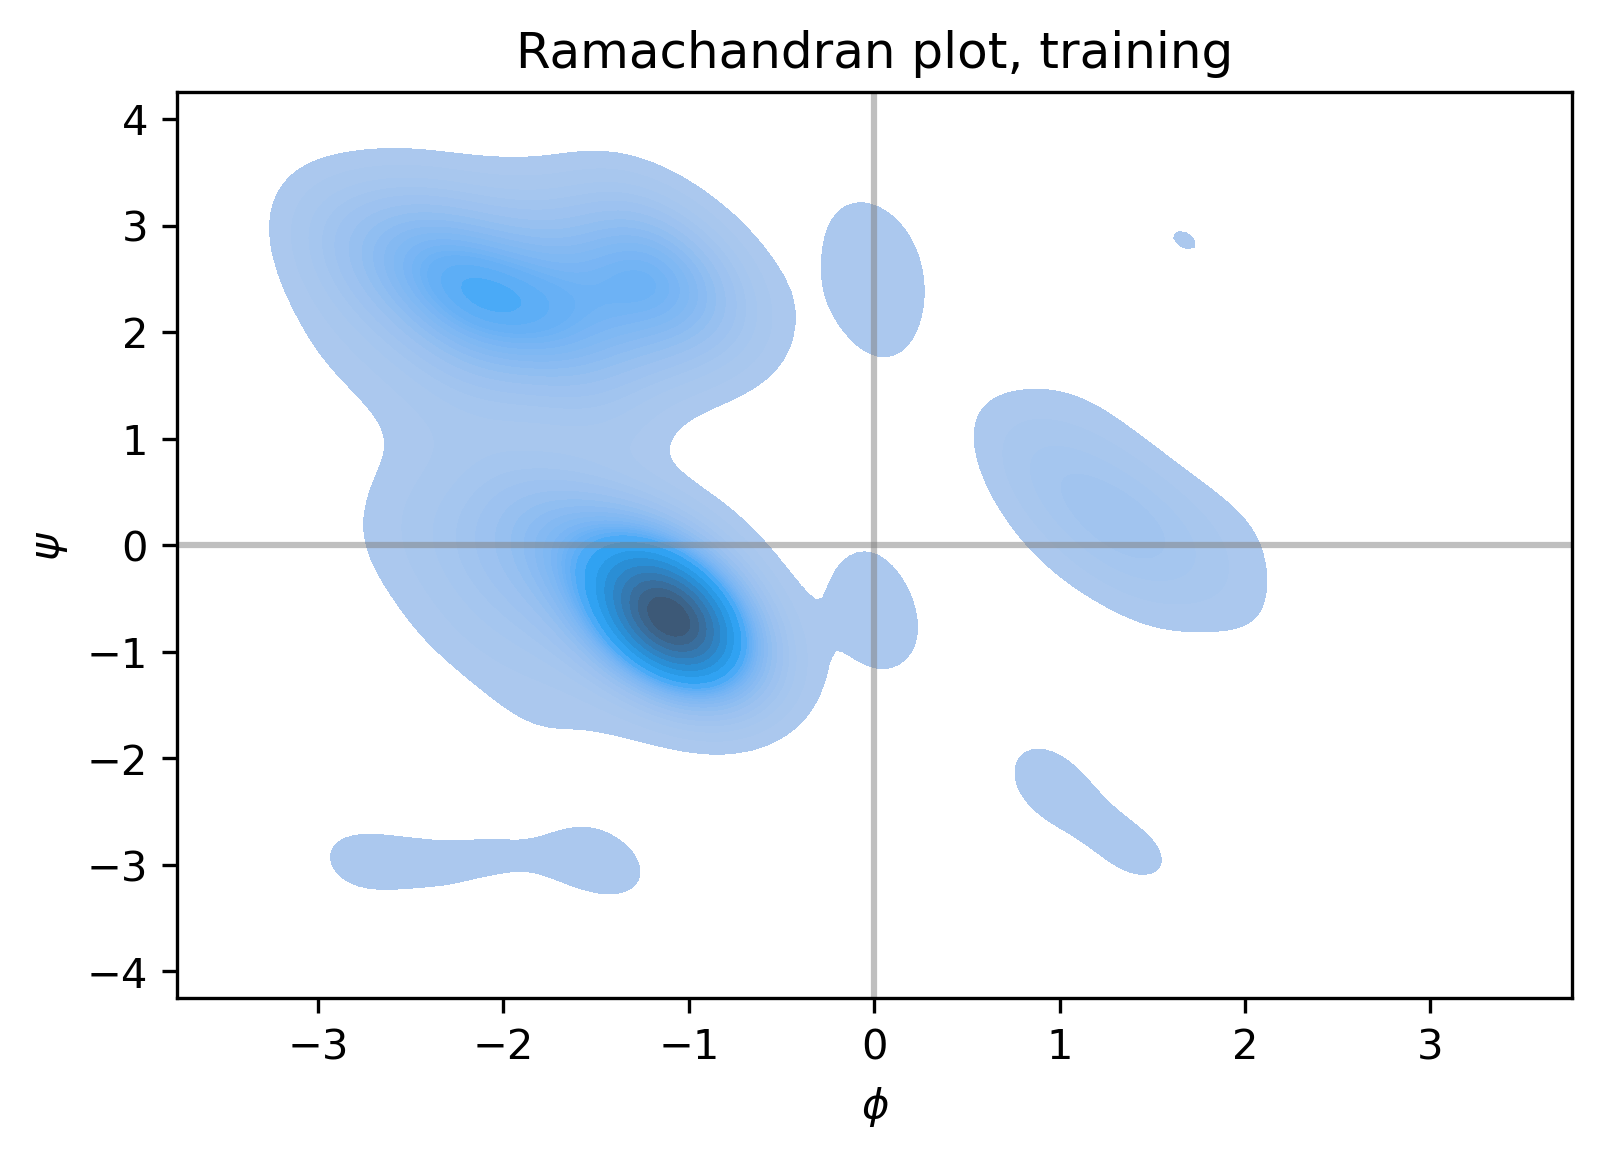

In [8]:
# Plot ramachandran plot
importlib.reload(plotting)

phi_idx = train_dset.dset.feature_names['angles'].index('phi')
psi_idx = train_dset.dset.feature_names['angles'].index('psi')

plotting.plot_joint_kde(
    train_values_stacked[:5000, phi_idx],
    train_values_stacked[:5000, psi_idx],
    xlabel="$\phi$",
    ylabel="$\psi$",
    title="Ramachandran plot, training",
).show()

In [9]:
importlib.reload(modelling)
model = modelling.BertForDiffusion.from_dir(MODEL_DIR, legacy=is_legacy).to(torch.device('cuda'))
model.n_inputs

INFO:root:Loading model assuminsg new file structure
INFO:root:Found 13 checkpoints
INFO:root:Loading weights from /home/t-kevinwu/amlt/top-bengal/cath_full_run/results/models/best_by_valid/epoch=1494-step=590525.ckpt
INFO:torch.distributed.nn.jit.instantiator:Created a temporary directory at /tmp/tmp3lf04eoy
INFO:torch.distributed.nn.jit.instantiator:Writing /tmp/tmp3lf04eoy/_remote_module_non_scriptable.py
INFO:root:Mapping loss smooth_l1 to list of losses corresponding to angular [False, True, True, True]
Using loss: [<function smooth_l1_loss at 0x7f53fc7a90d0>, functools.partial(<function radian_smooth_l1_loss at 0x7f53f3f18d30>, beta=0.3141592653589793), functools.partial(<function radian_smooth_l1_loss at 0x7f53f3f18d30>, beta=0.3141592653589793), functools.partial(<function radian_smooth_l1_loss at 0x7f53f3f18d30>, beta=0.3141592653589793)]
Using time embedding: GaussianFourierProjection()


4

torch.Size([256, 512, 4])


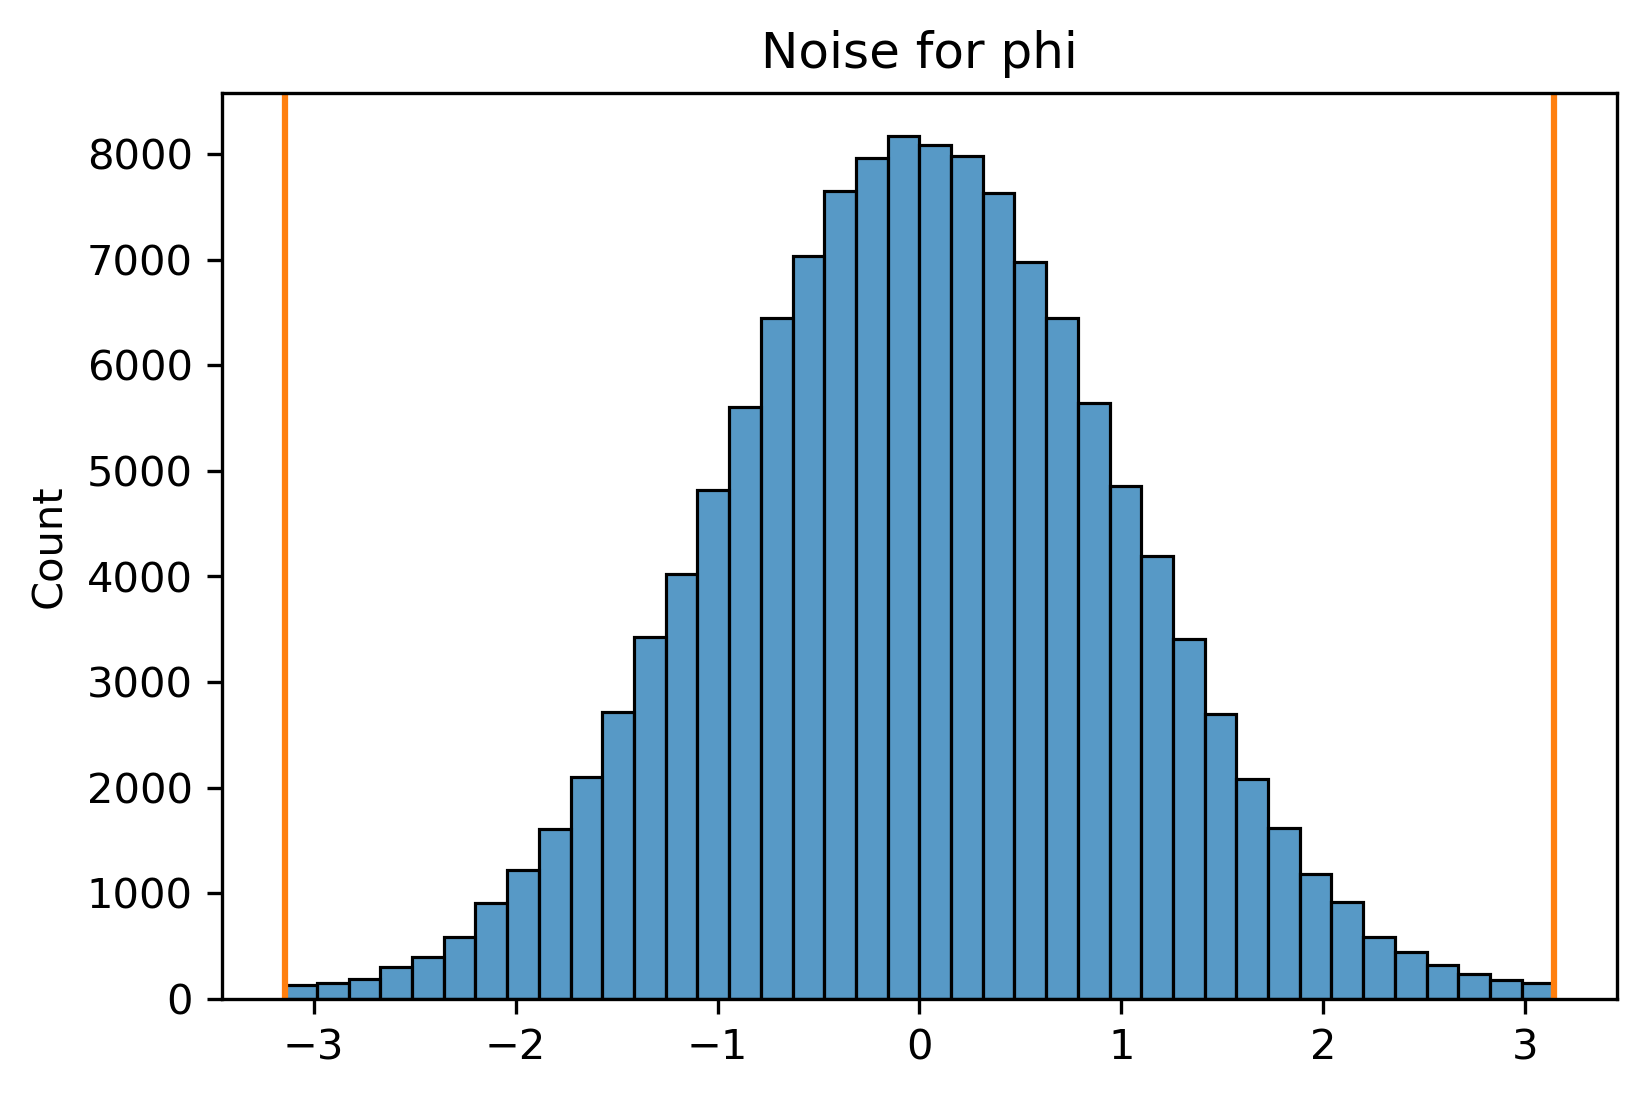

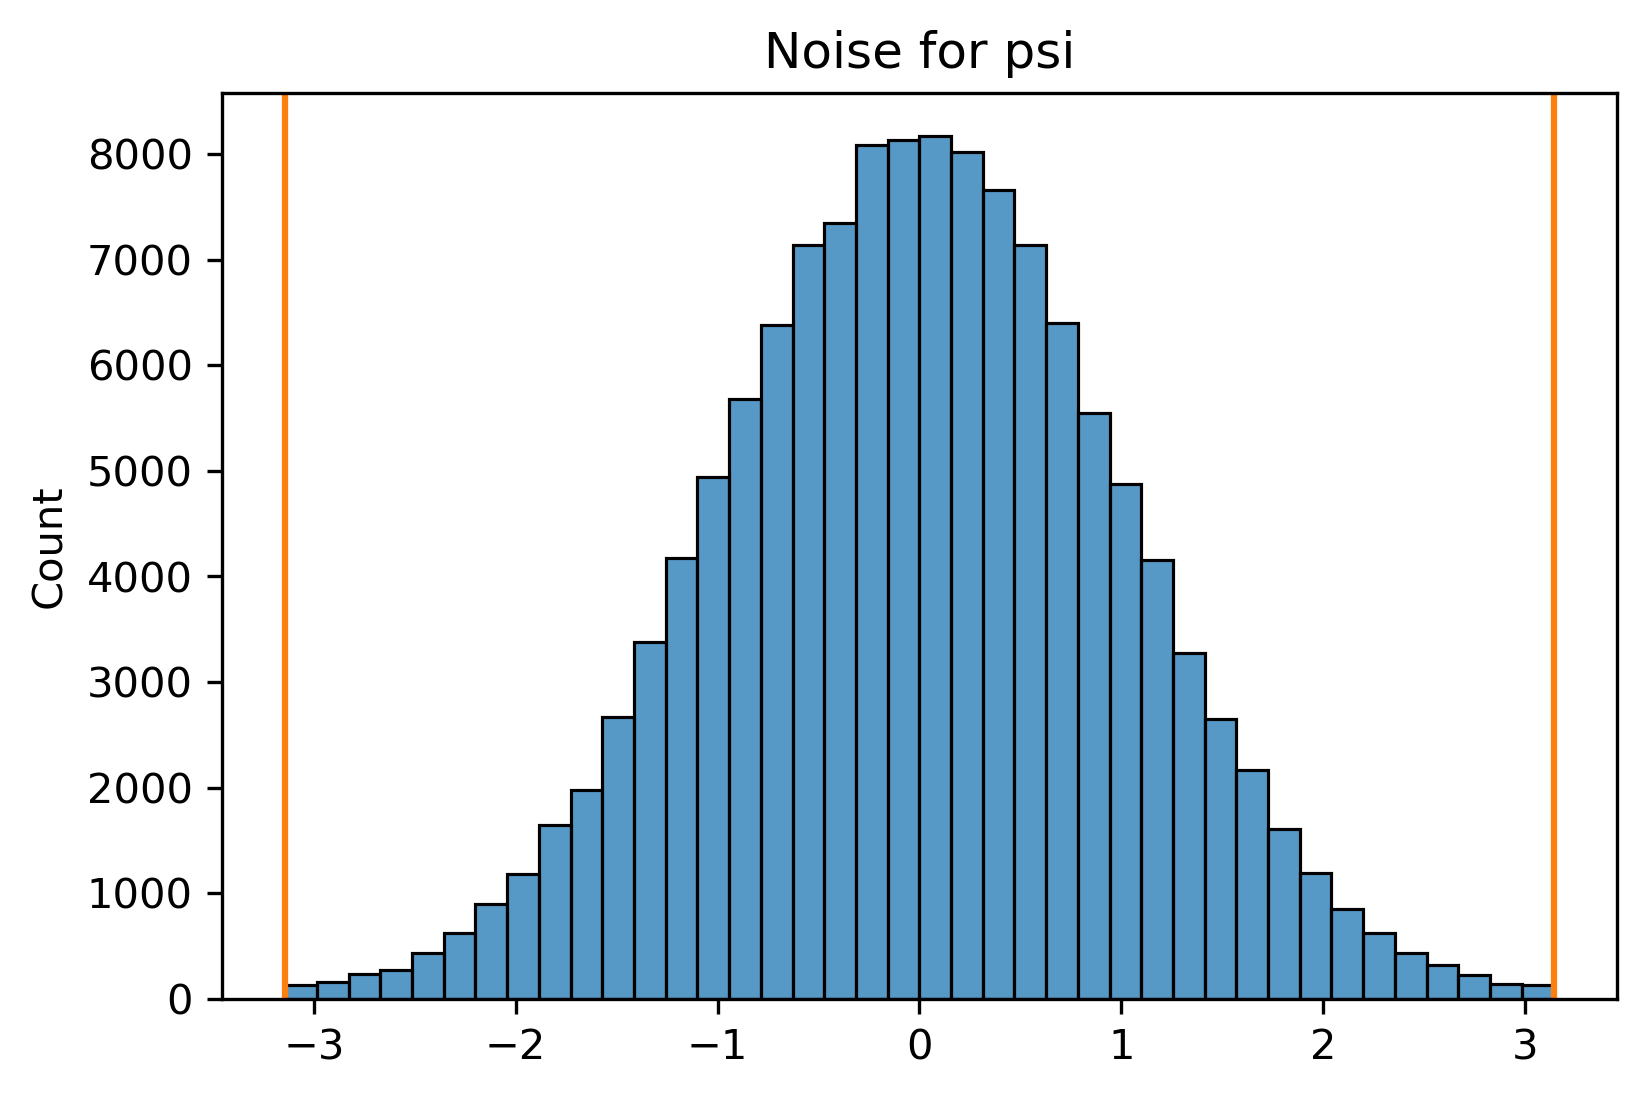

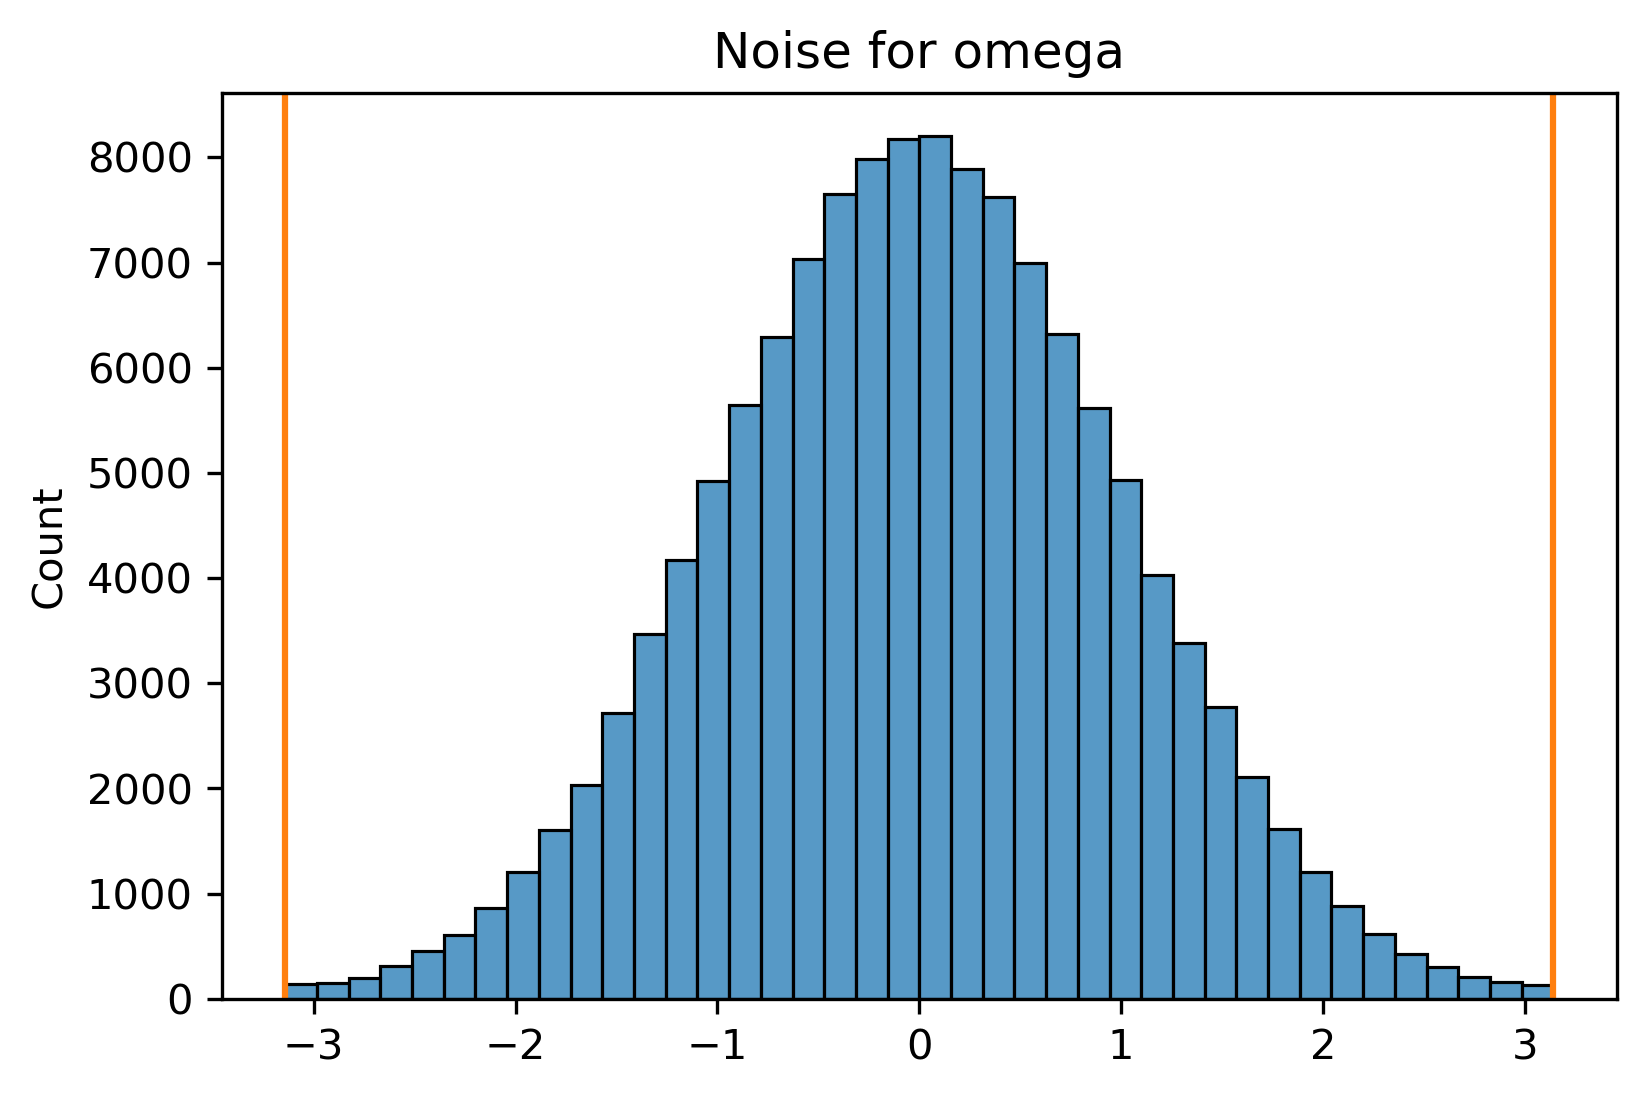

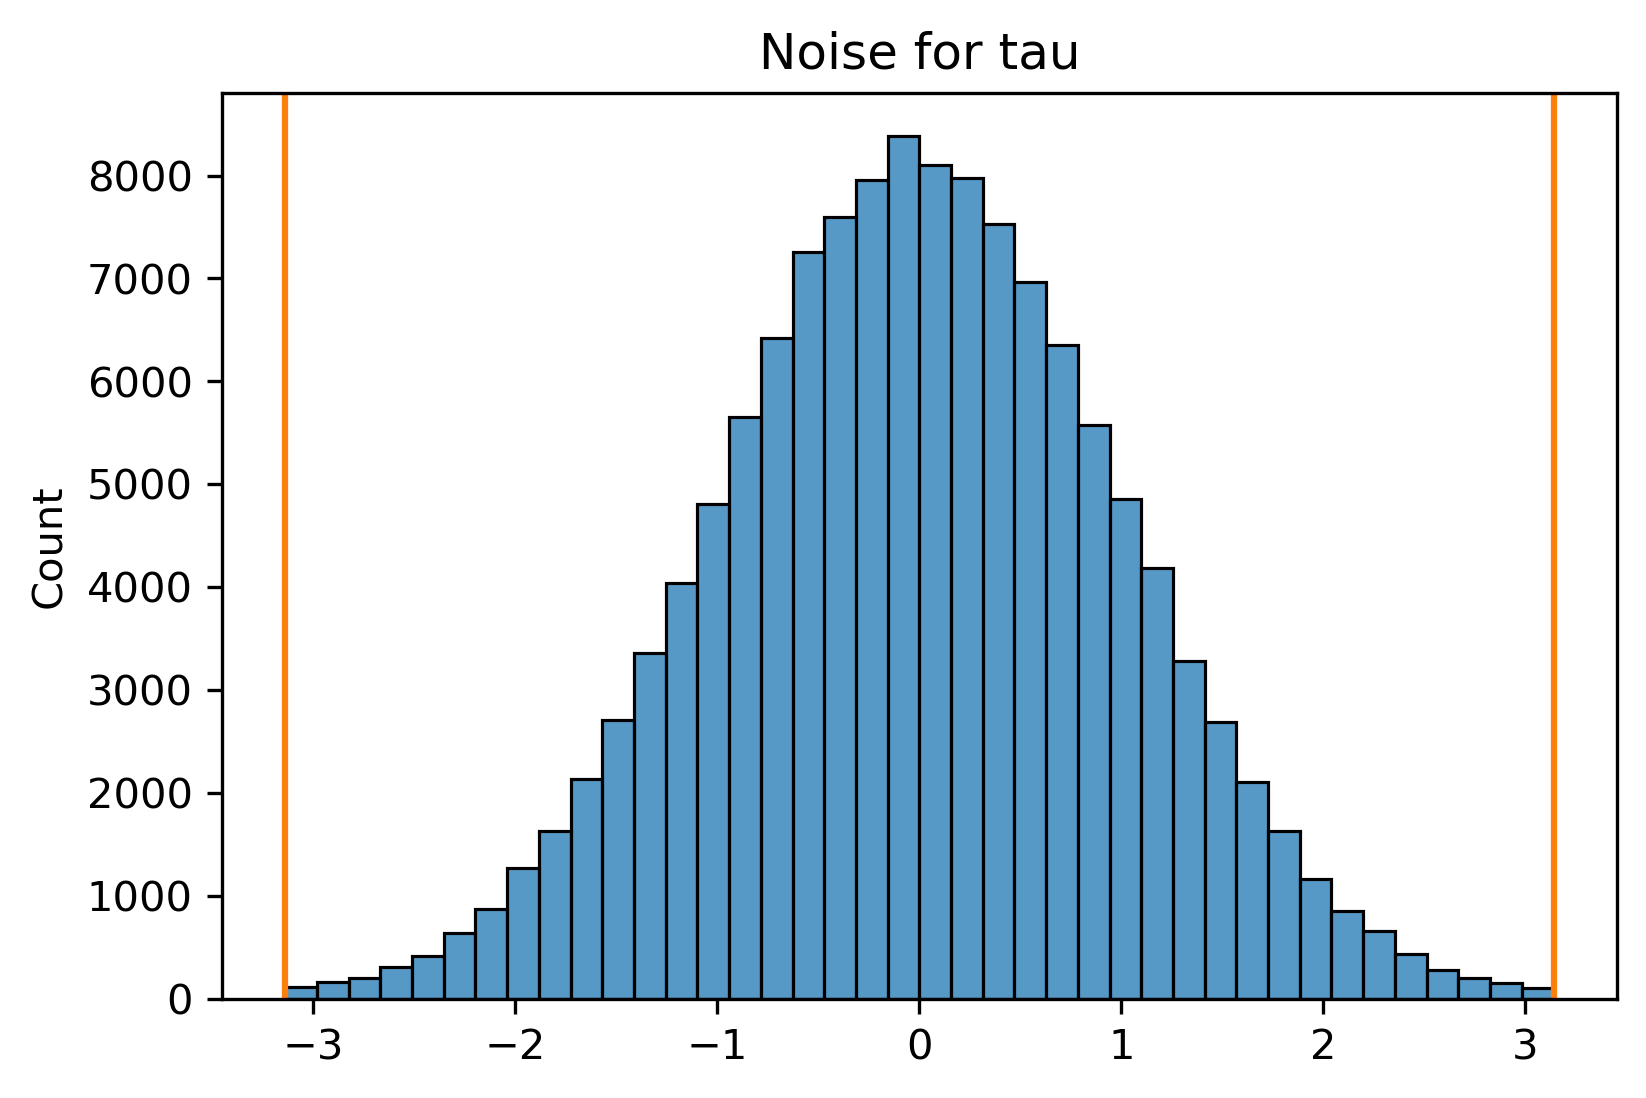

In [10]:
importlib.reload(sampling)

n = 256

# Selects the noise for angle
noise = train_dset.sample_noise(
    torch.zeros((n, 512, model.n_inputs), dtype=torch.float32)
)
print(noise.shape)

for i in range(model.n_inputs):
    ft_name = train_dset.dset.feature_names['angles'][i]

    fig, ax = plt.subplots(dpi=300)
    sns.histplot(noise.numpy()[:, :, i].flatten(), bins=40, ax=ax)
    ax.set(title=f"Noise for {ft_name}")
    ax.axvline(-np.pi, color='tab:orange')
    ax.axvline(np.pi, color='tab:orange')
    fig.show()

In [11]:
importlib.reload(sampling)

sampled = sampling.sample(
    model,
    train_dset,
    n=n,
)
sampled[0].shape

INFO:root:Starting from noise torch.Size([256, 512, 4]) with modulo None and range tensor([-3.1397, -3.1400, -3.1409, -3.1411], device='cuda:0') - tensor([3.1393, 3.1402, 3.1381, 3.1403], device='cuda:0') using cuda:0


sampling loop time step:   0%|          | 0/250 [00:00<?, ?it/s]

torch.Size([250, 198, 4])

In [12]:
final_sampled = [s[-1] for s in sampled]
final_sampled[0].shape

torch.Size([198, 4])

In [13]:
final_sampled_flat = torch.cat(final_sampled, dim=0).squeeze()
final_sampled_flat.shape

torch.Size([39061, 4])

In [14]:
final_sampled_flat[:3]

tensor([[ 0.0213,  2.8305,  0.0279,  1.9472],
        [-2.4127, -0.7743,  1.5178,  2.0419],
        [-1.0837, -0.4807,  1.6850,  1.9209]])

In [15]:
train_dset.dset.feature_names['angles']

['phi', 'psi', 'omega', 'tau']

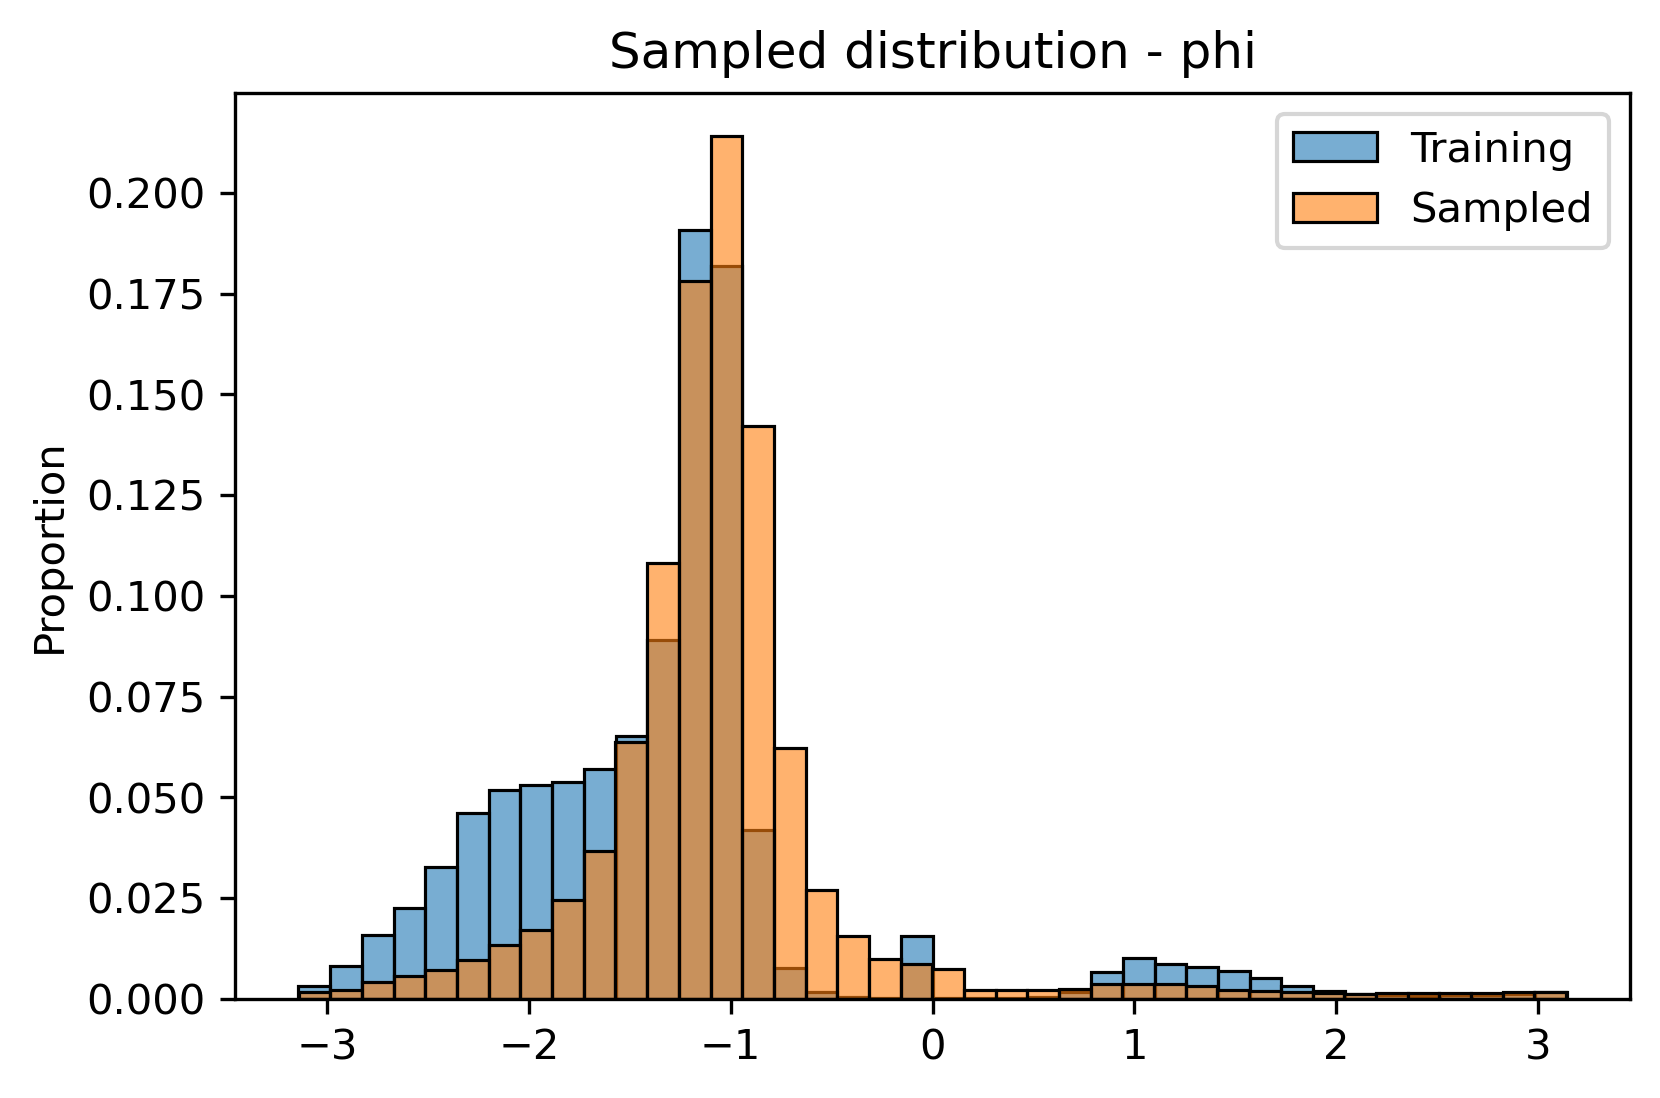

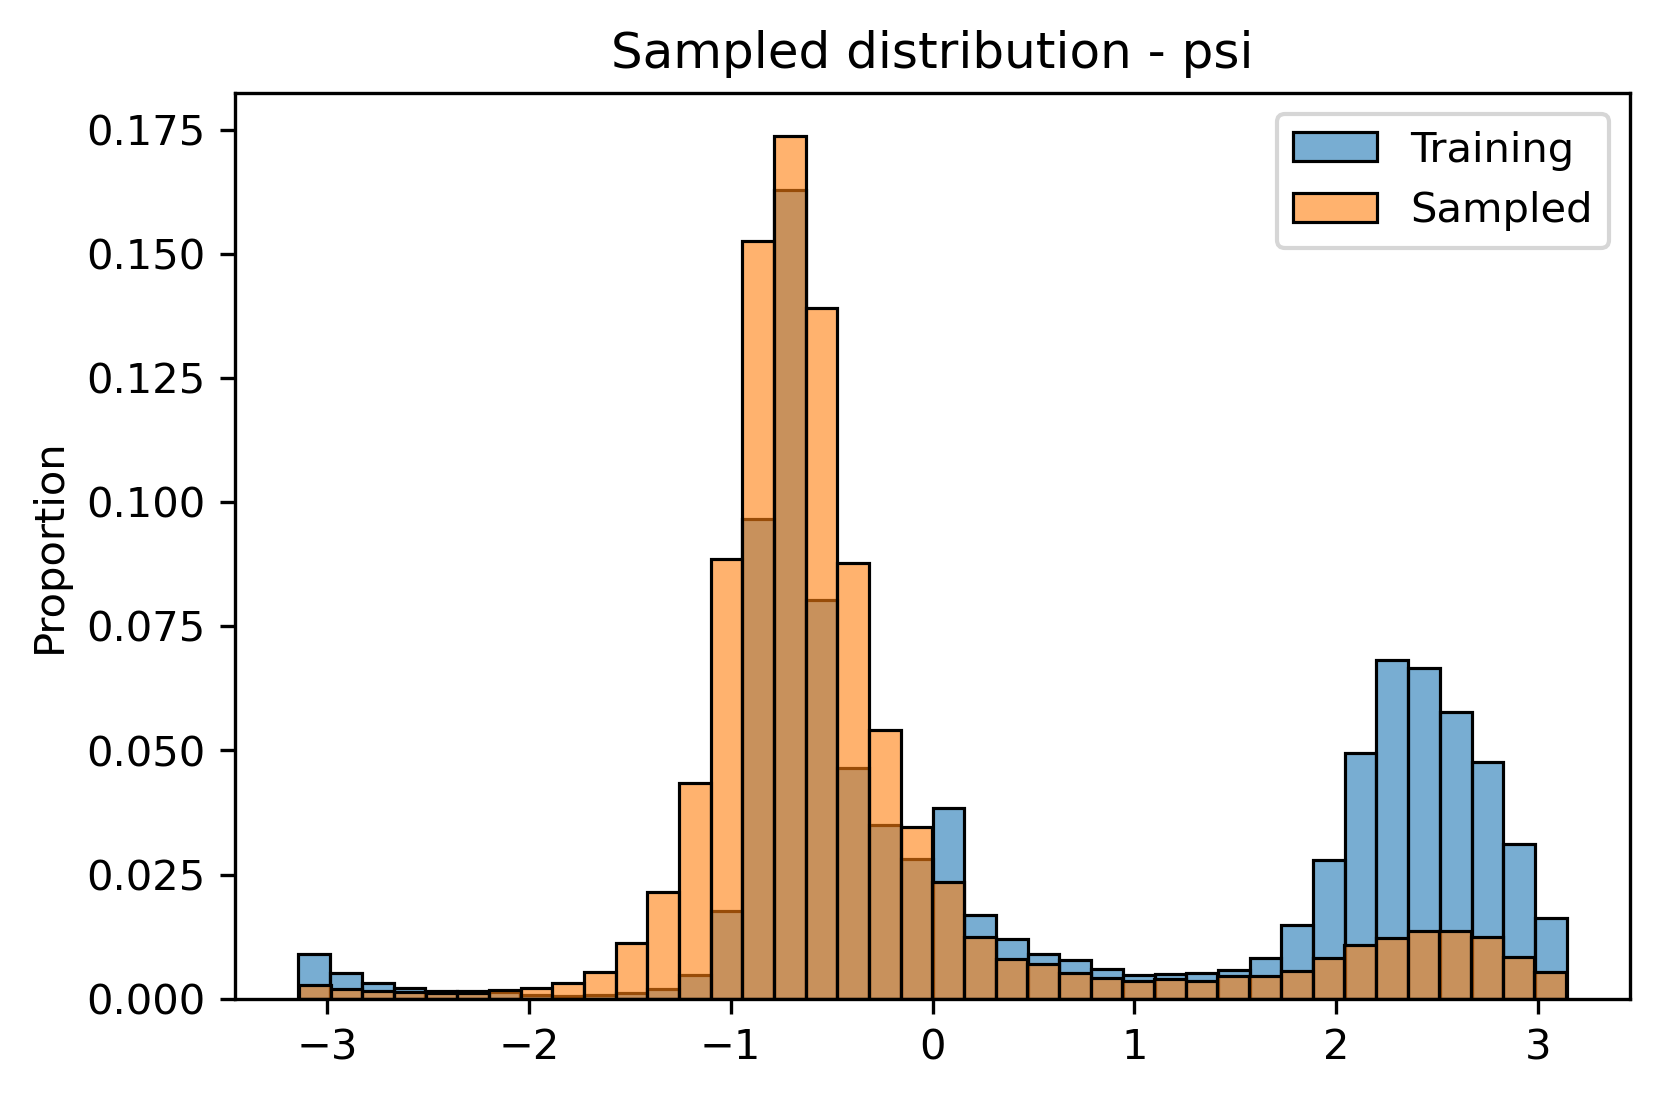

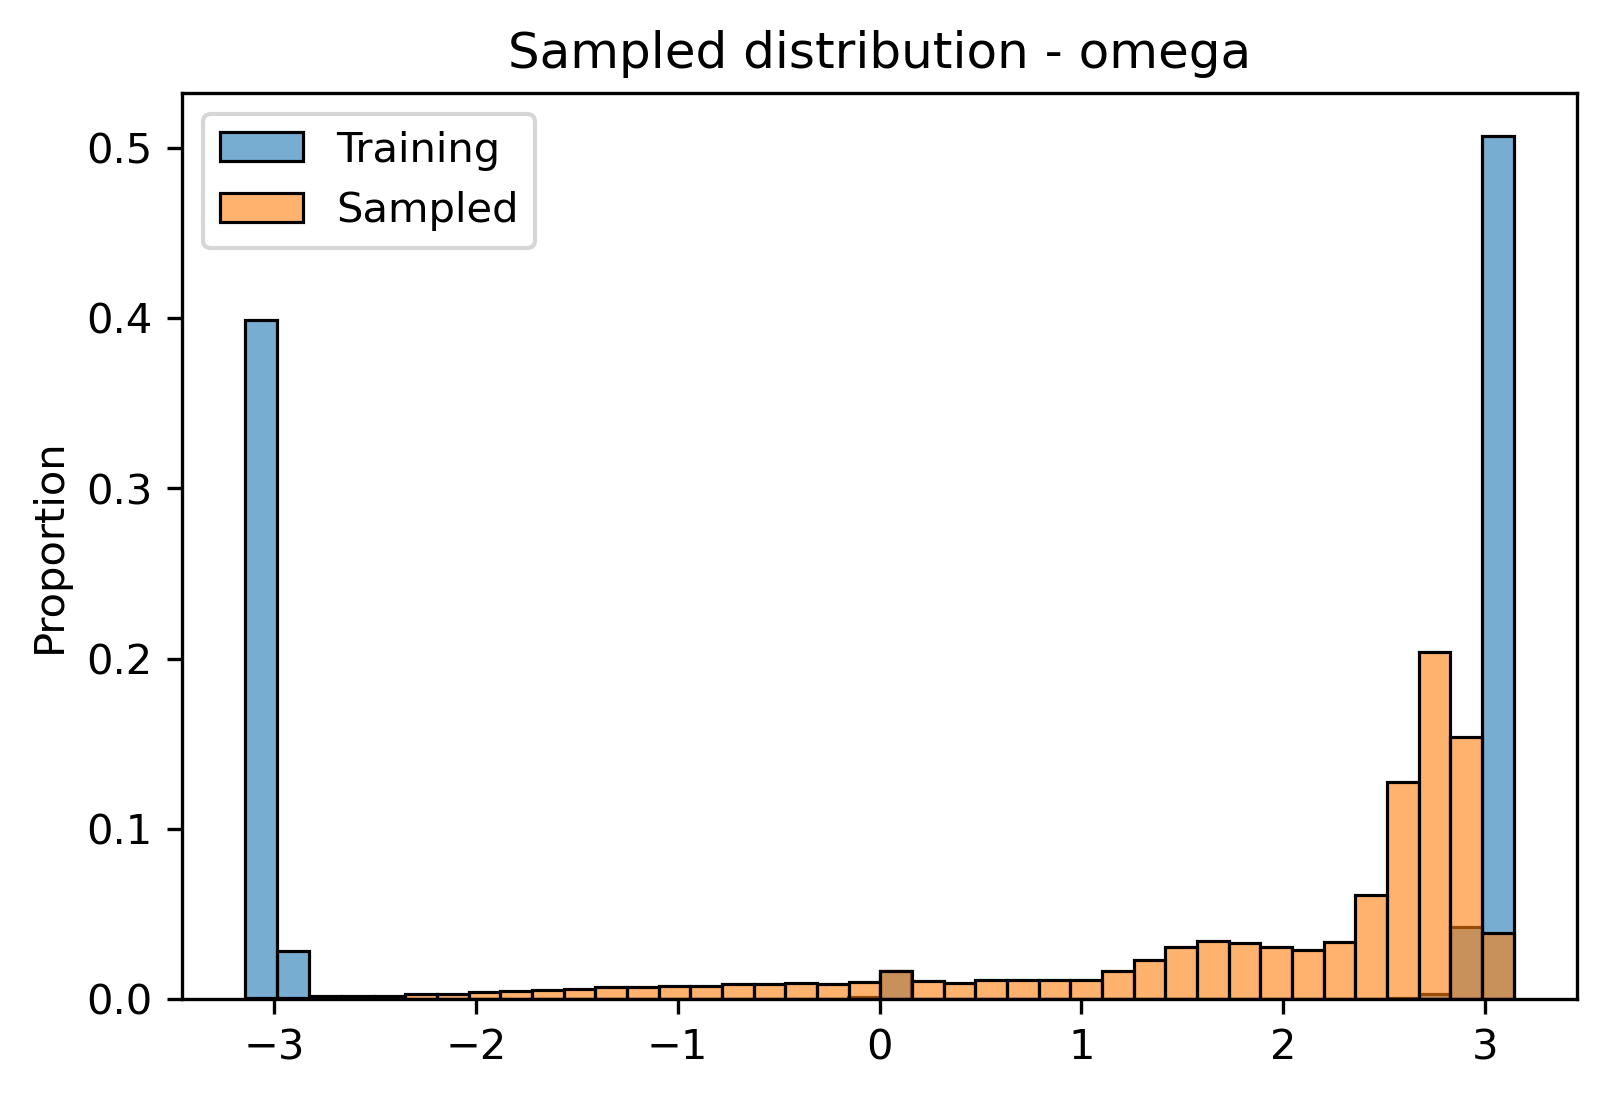

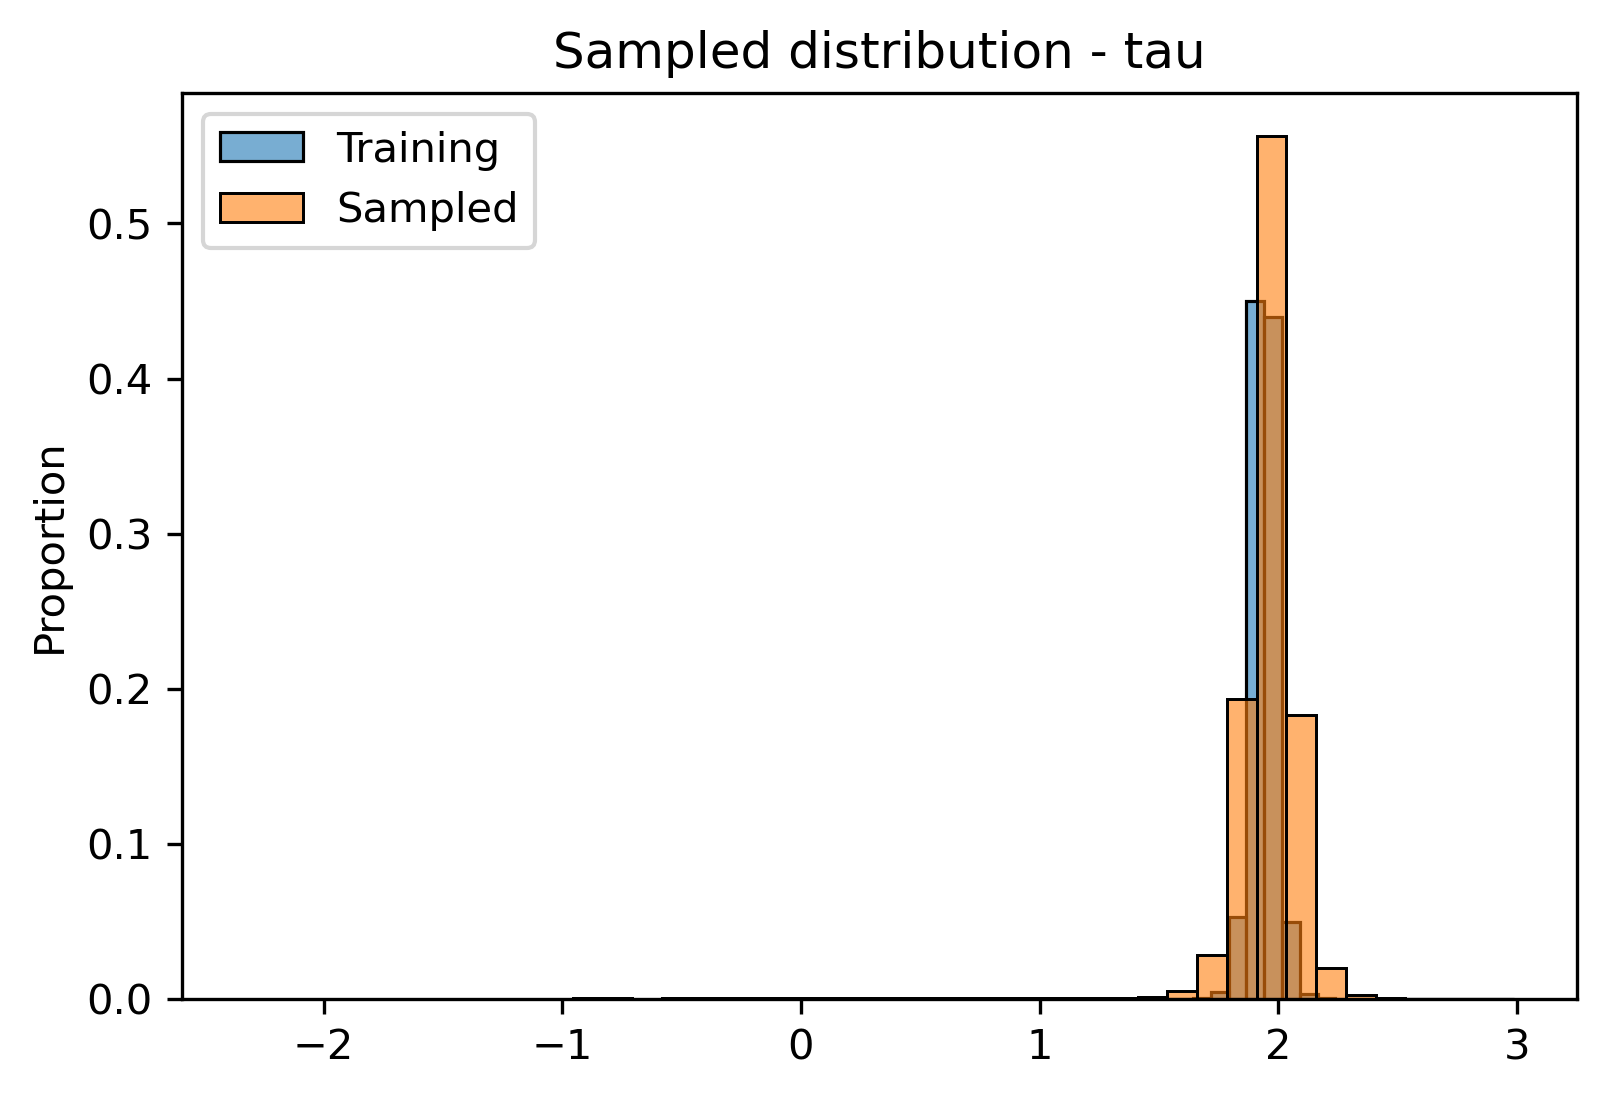

In [16]:
for i in range(model.n_inputs):
    ft_name = train_dset.dset.feature_names['angles'][i]

    fig, ax = plt.subplots(dpi=300)
    sns.histplot(train_values_stacked[:, i].numpy(), bins=40, stat='proportion',
        ax=ax, label='Training', color='tab:blue', alpha=0.6)
    sns.histplot(final_sampled_flat[:, i].numpy(), bins=40, stat='proportion', 
        ax=ax, label='Sampled', color='tab:orange', alpha=0.6)
    ax.set(title=f"Sampled distribution - {ft_name}")
    ax.legend()
    fig.show()

In [17]:
final_sampled_flat.shape

torch.Size([39061, 4])

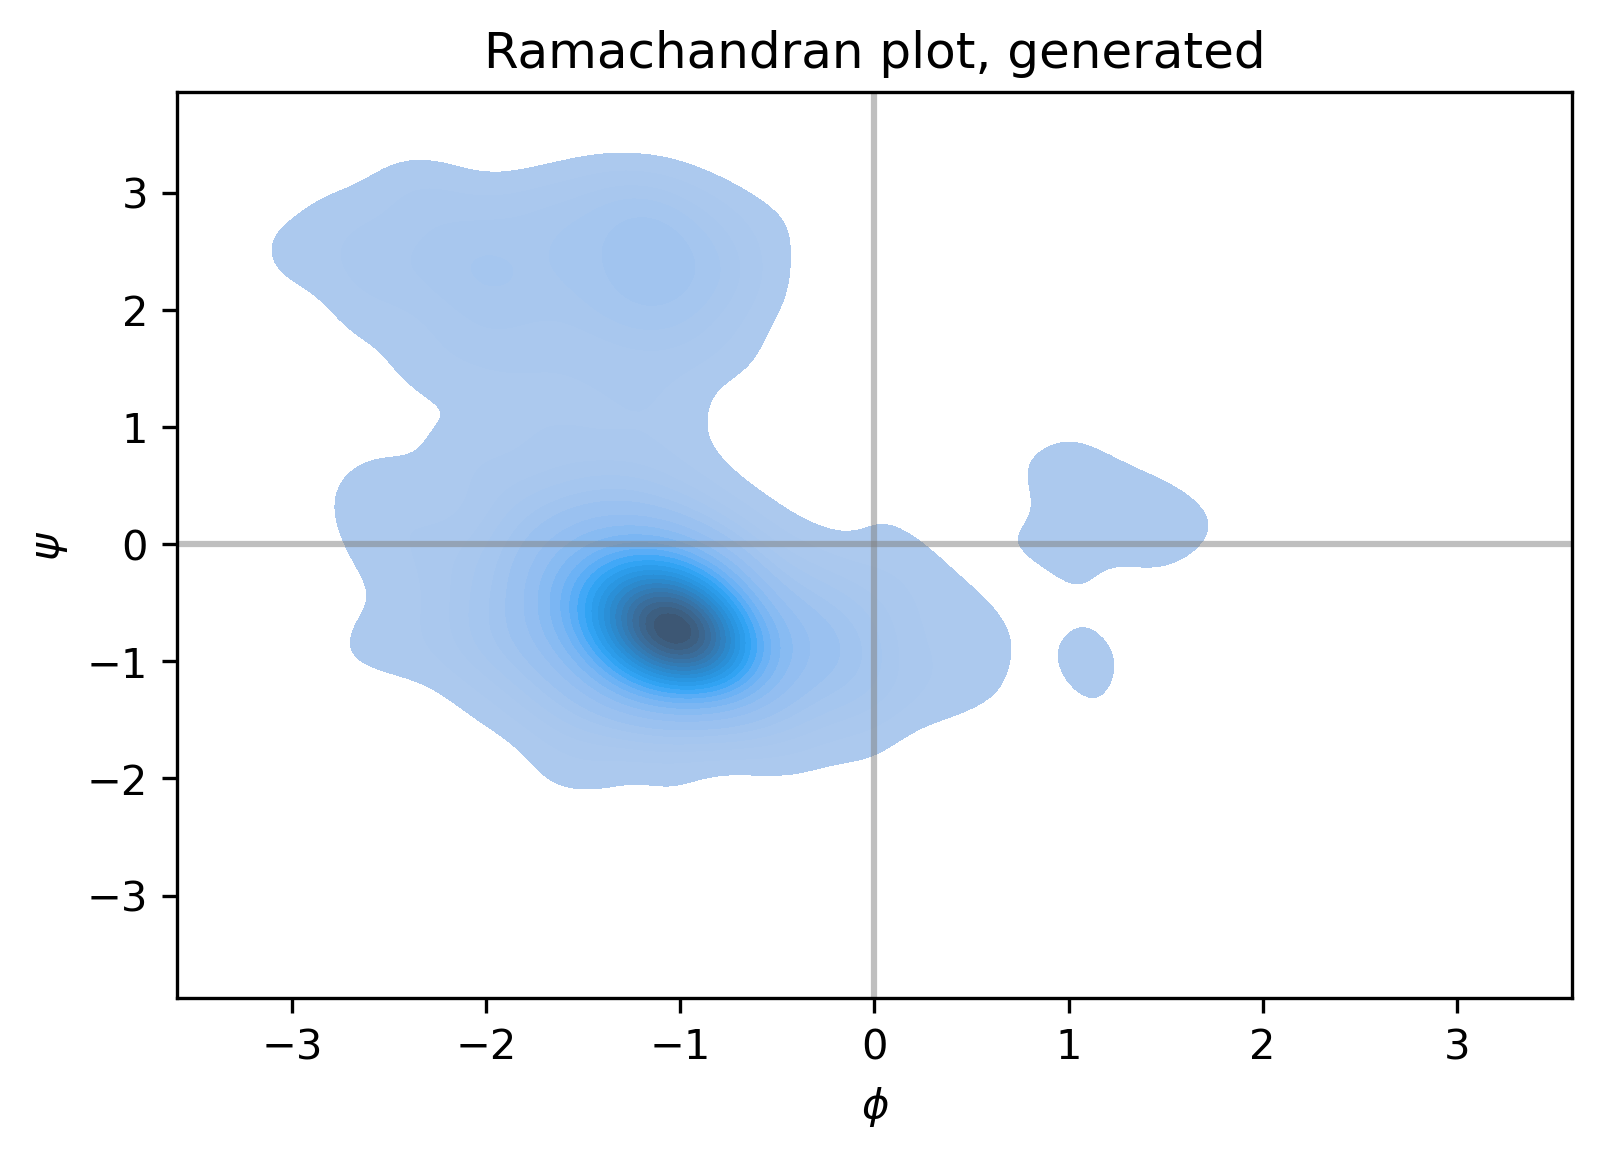

In [18]:
plotting.plot_joint_kde(
    final_sampled_flat[:5000, phi_idx],
    final_sampled_flat[:5000, psi_idx],
    xlabel="$\phi$",
    ylabel="$\psi$",
    title="Ramachandran plot, generated",
).show()

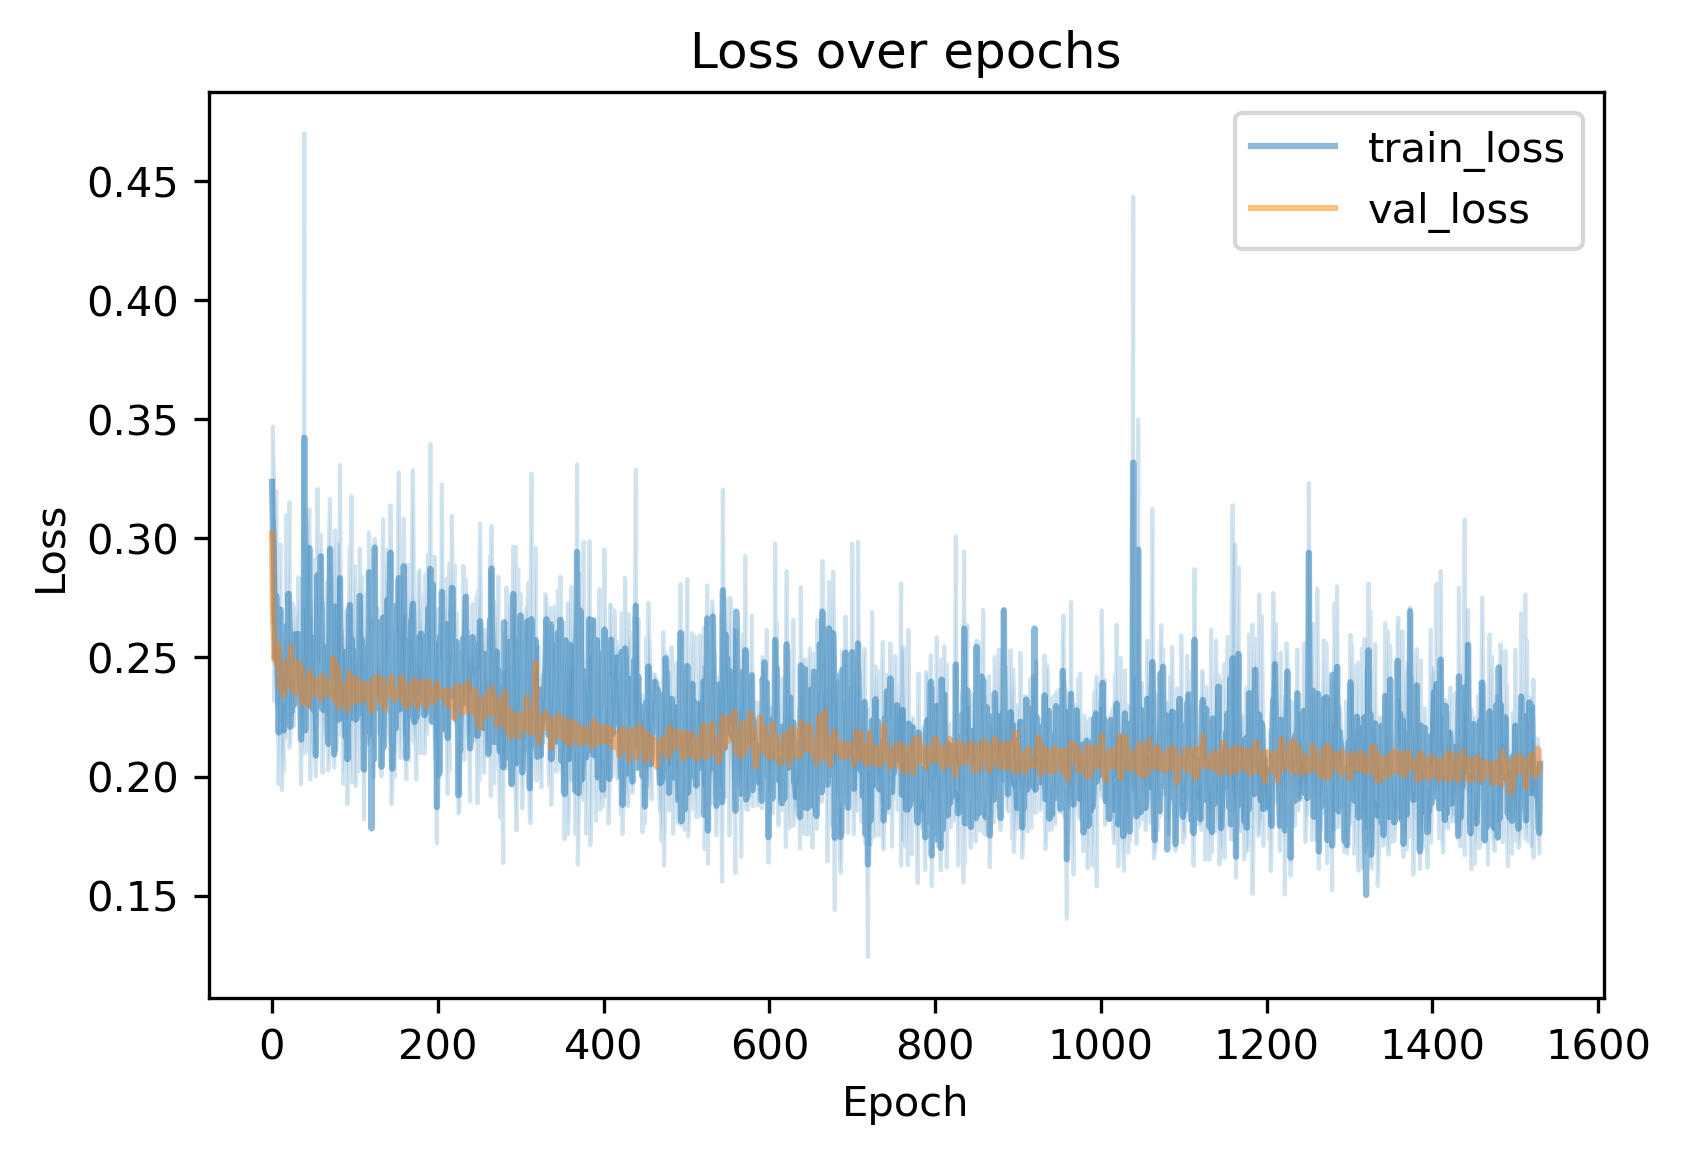

In [19]:
# Plot losses

metrics_file = os.path.join(MODEL_DIR, "logs/lightning_logs/version_0/metrics.csv")
assert os.path.isfile(metrics_file), f"Metrics file not found: {metrics_file}"

plotting.plot_losses(metrics_file, simple=True).show()

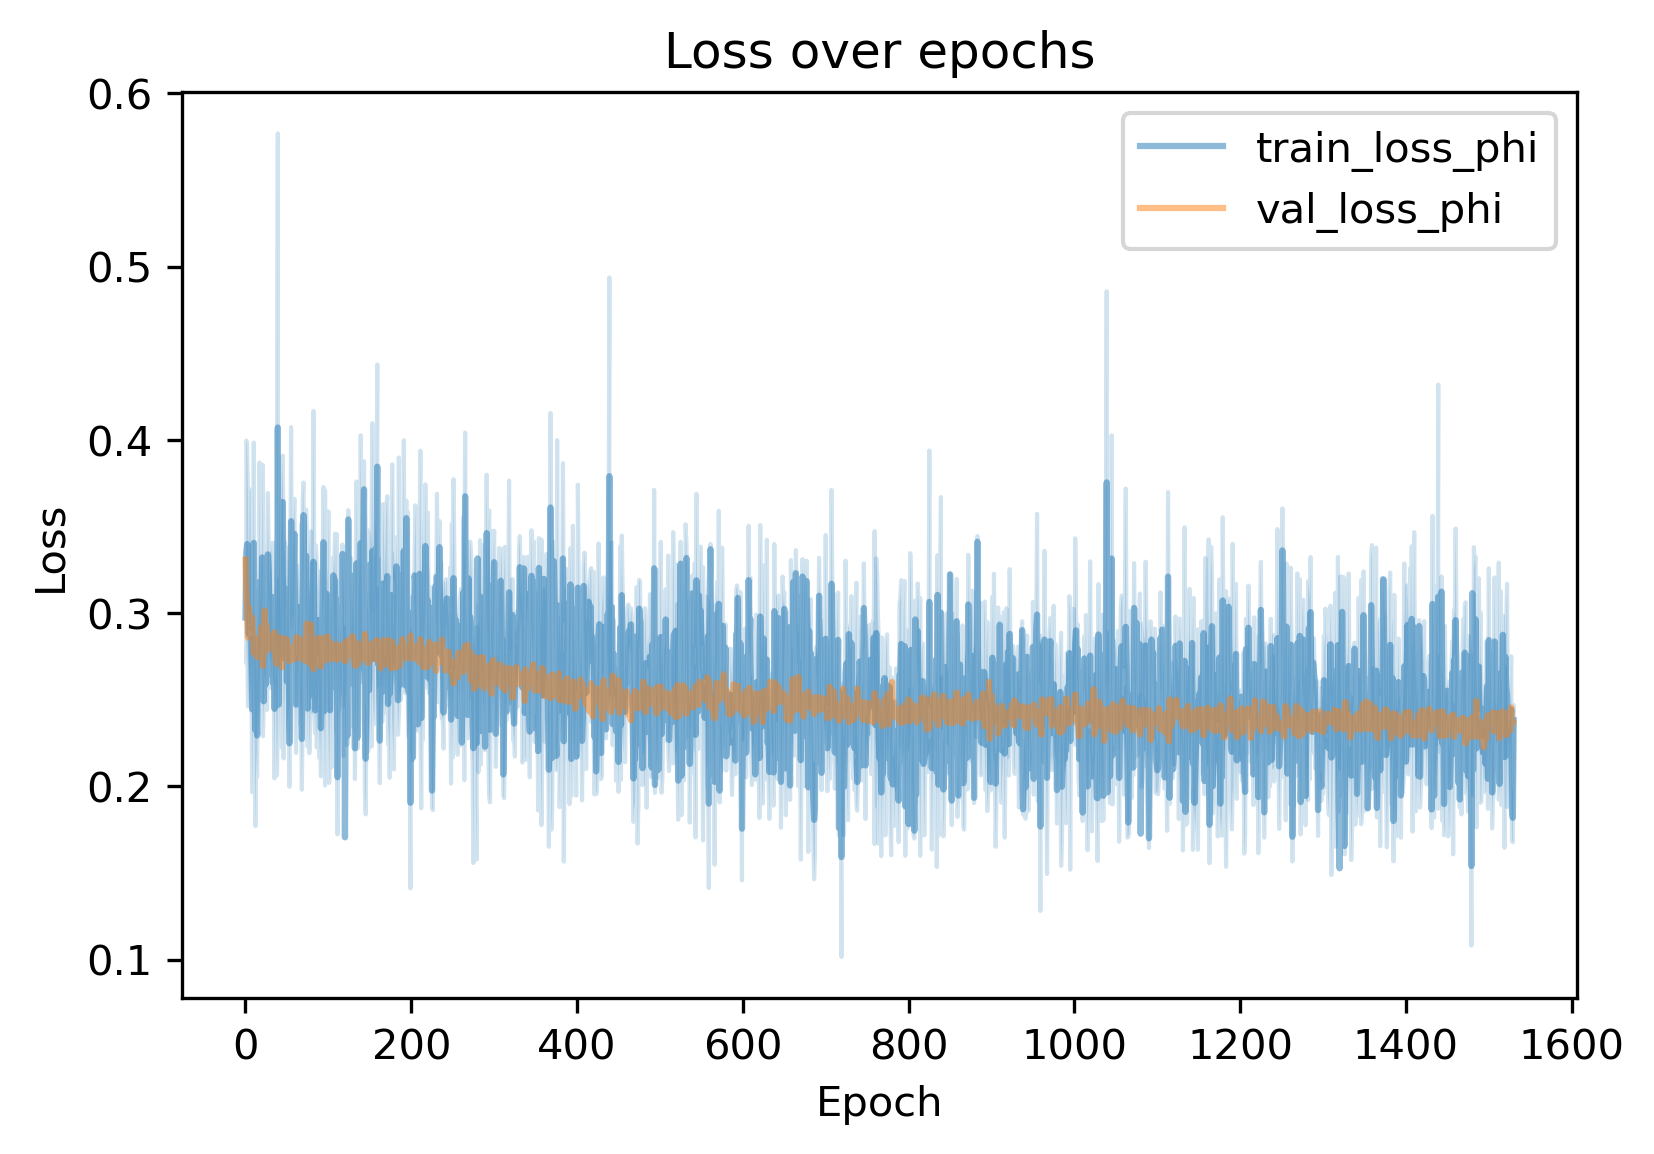

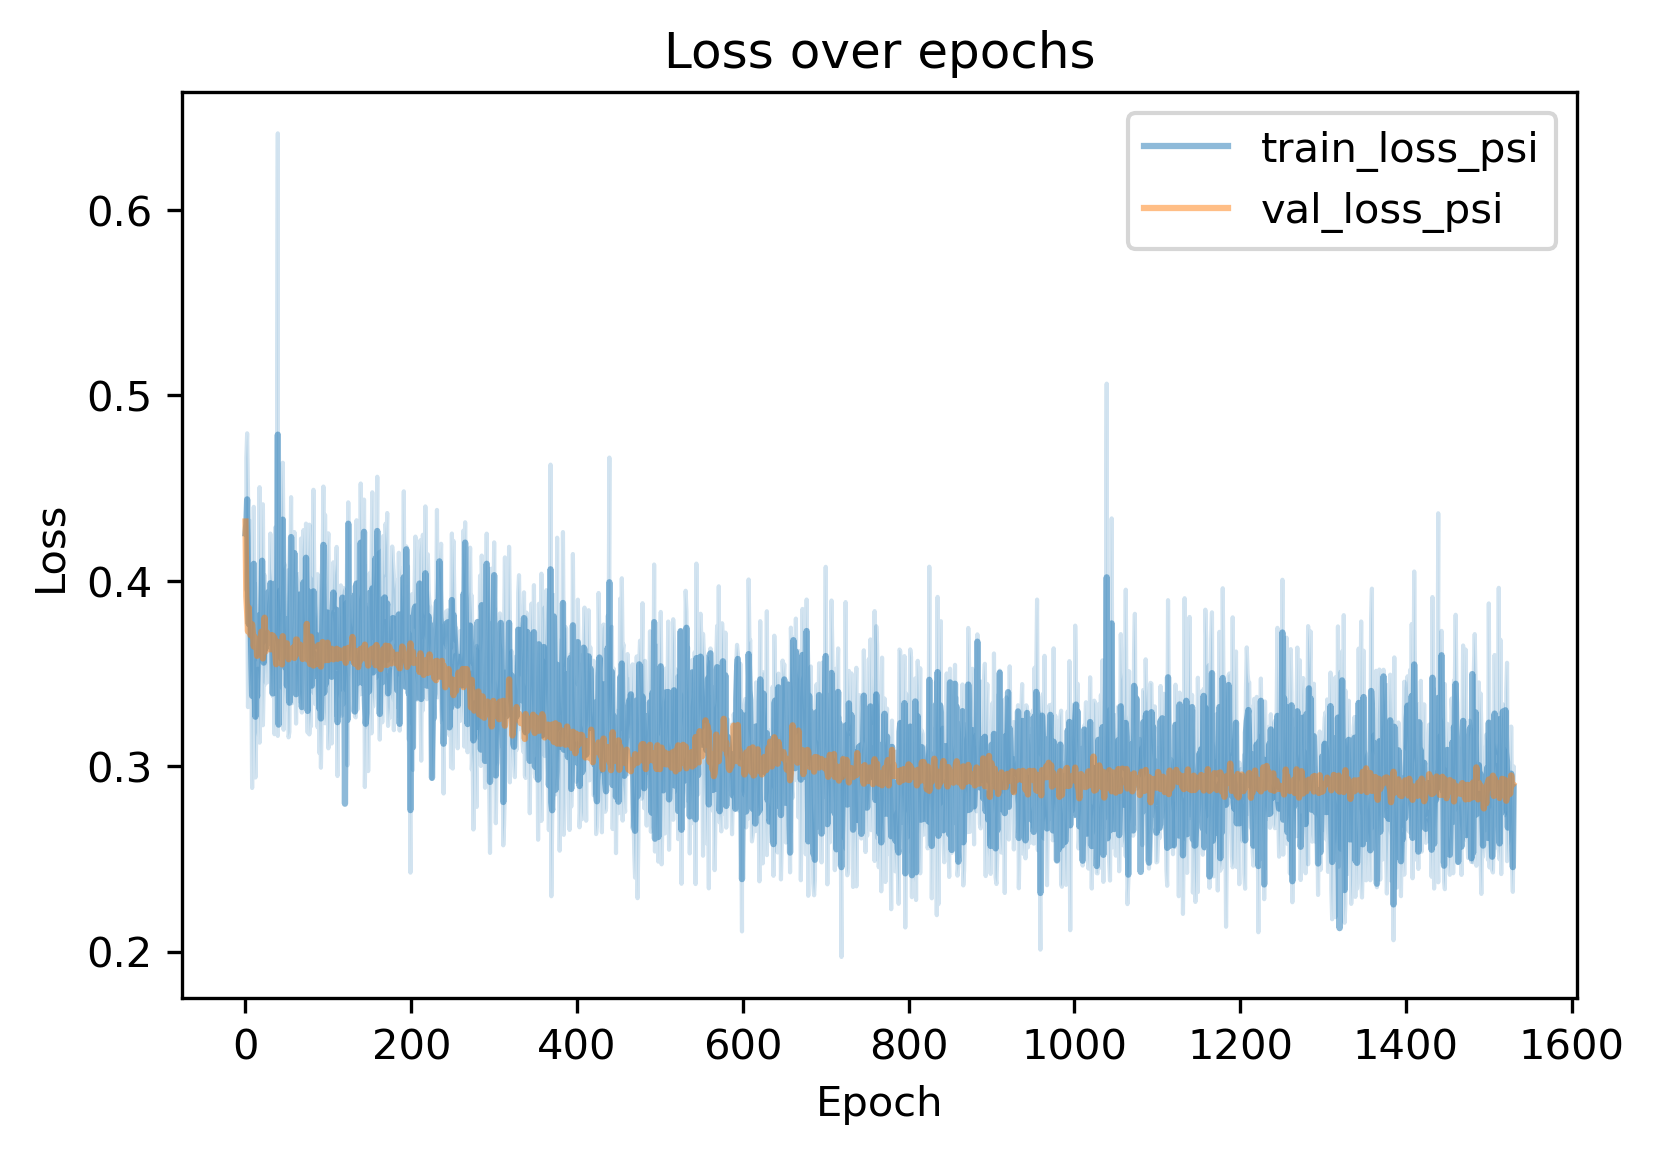

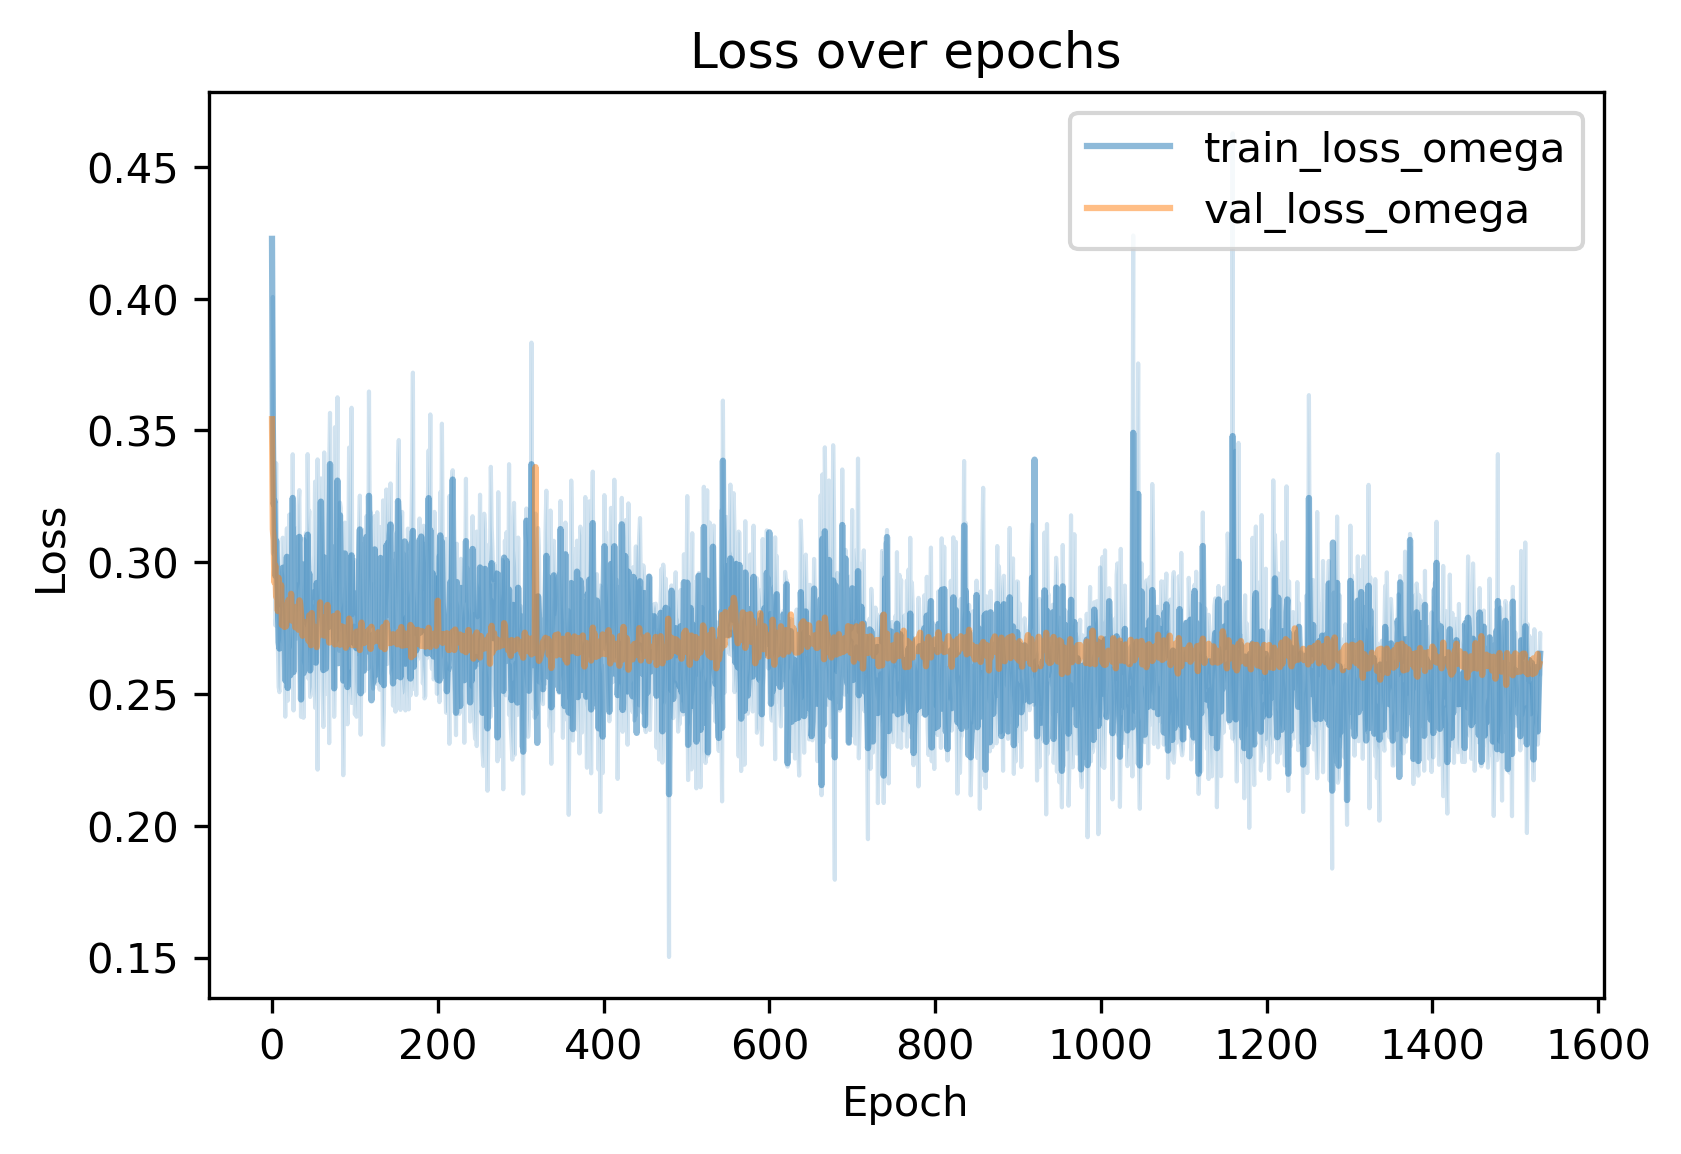

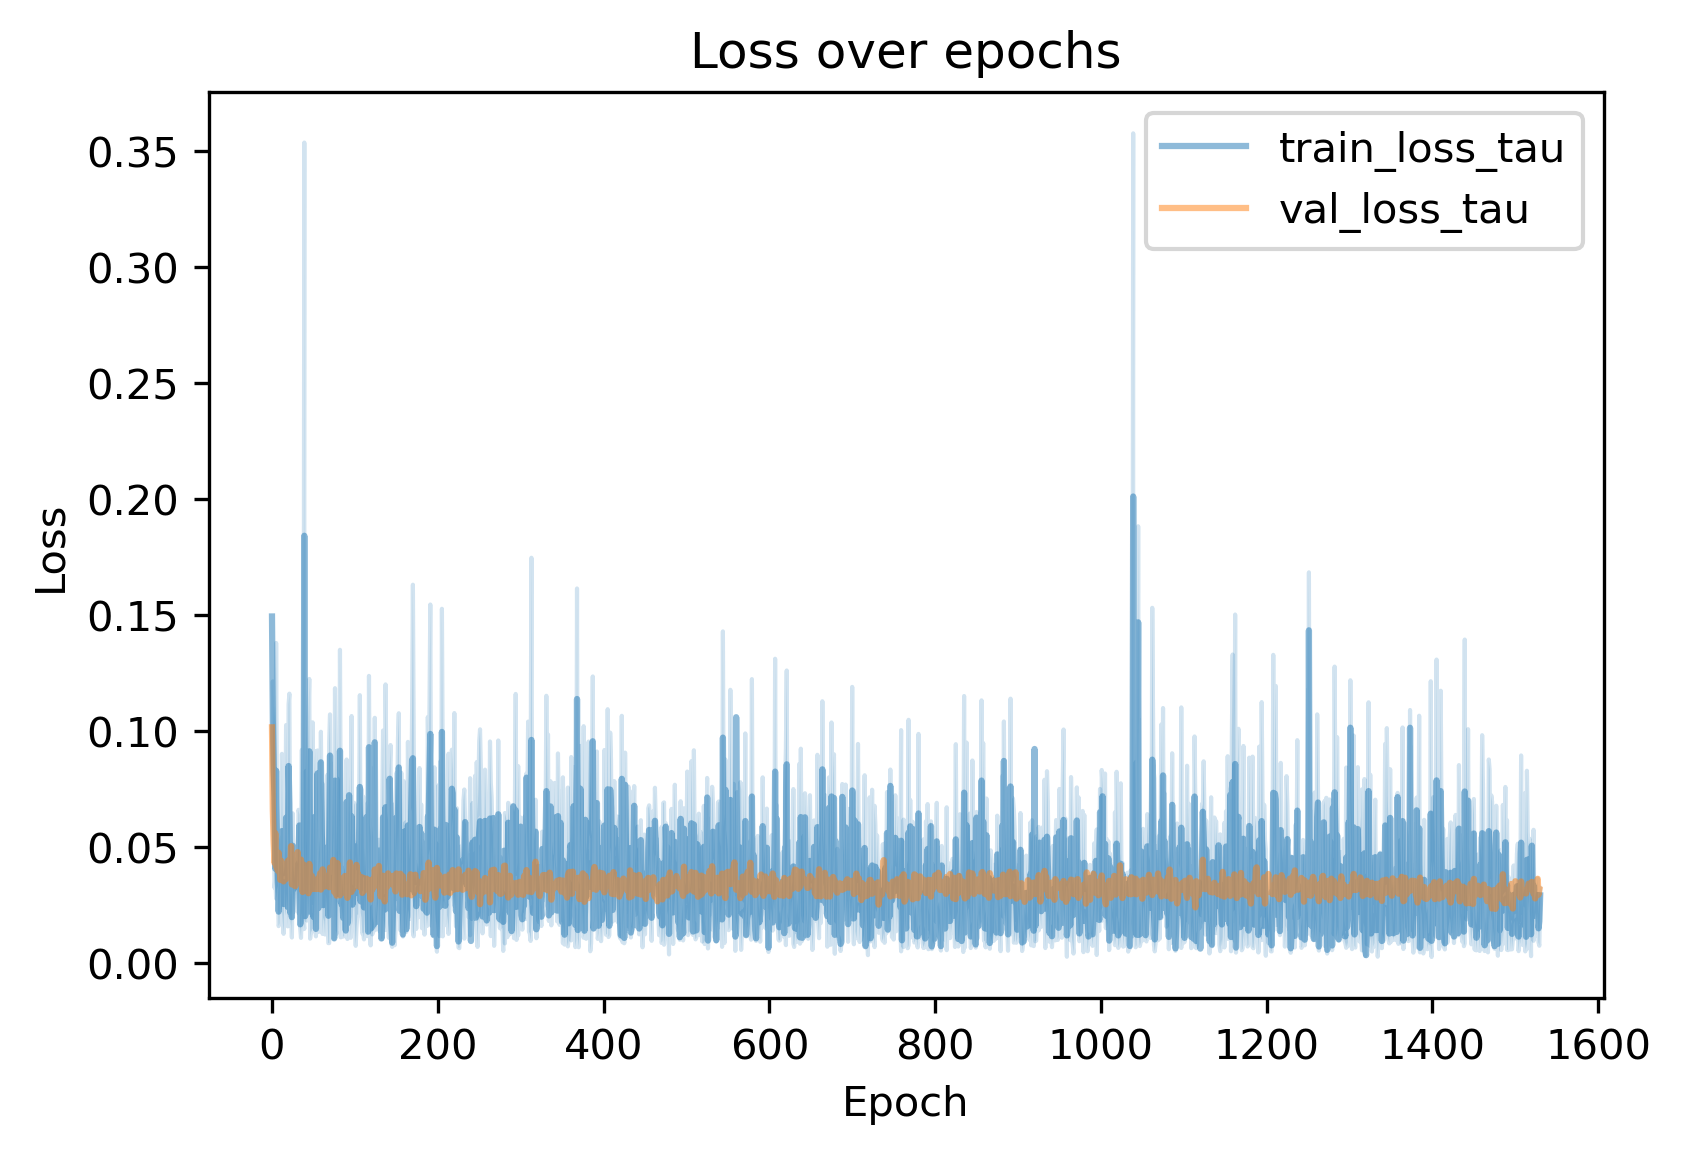

In [20]:
importlib.reload(plotting)

for feature in train_dset.dset.feature_names['angles']:
    plotting.plot_losses(metrics_file, pattern=f"loss_{feature}").show()